## Simple Univariate Model

After collecting the data, I want to get baseline results by seeing how much predictive power previous levels of HPI have on predicting future HPI.

I will train and assess a variety of models separately for each city, including simple AR, ARMA, and ARIMA.

#### Importing Packages

In [3]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import fred_msa
import ts_functions
import datetime as dt
from datetime import date
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

#### Ingesting Data

In [2]:
hpi = pd.read_csv('..\\working-data\\hpi-data.csv')
hpi = hpi.query("year <= 2019")
hpi.date = pd.to_datetime(hpi.date)
#hpi = hpi.set_index(['city', 'msa_state', 'date'])

#### Examine Stationarity Using the Augmented Dickey-Fuller Test

In [7]:
adf_p = {}
for city in hpi.city.unique():
    adf_p[city] = adfuller(hpi[hpi.city==city].hpi)[1]

In [13]:
adf_df = pd.DataFrame(adf_p, index=['adf_pval']).T
adf_df.style.background_gradient(cmap = 'YlGnBu')

Surprisingly, a few cities are showing $p < 0.1$ for this test, implying that they fit the criteria for stationarity. I will examine these cities in more detail.

In [14]:
cities_to_examine = ['Charleston', 'Rockford', 'Trenton']

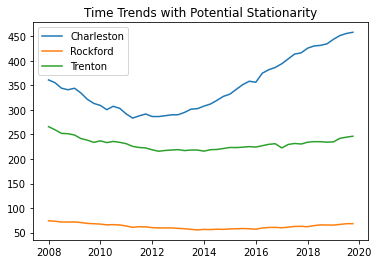

In [17]:
for city in cities_to_examine:
    plt.plot(hpi[hpi.city==city].set_index(['date']).hpi, label=city)
plt.legend()
plt.title('Time Trends with Potential Stationarity')
plt.show()

While the mean and variance look largely consistent for these cities, each of them follows a similar trend of dipping during and following the 2008 recession, then rising again afterwards. This matches the trend for other cities, so we can safely assume that despite the ADF results, **these trends are non-stationary.**

#### Examine Full and Partial Autocorrelation

In [11]:
ac_vals = []
pac_vals = []
for x in range (1, 21):
    ac_vals.append(hpi.groupby(['city'])['hpi'].apply(pd.Series.autocorr, lag=x).mean())
    pac_vals.append(hpi.groupby(['city'])['hpi'].apply(pacf, nlags=x).mean()[-1])

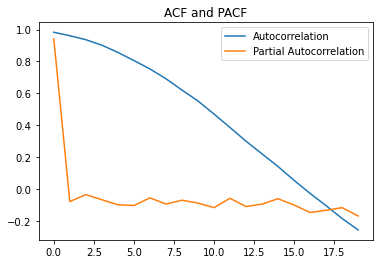

In [13]:
plt.plot(ac_vals, label='Autocorrelation')
plt.plot(pac_vals, label='Partial Autocorrelation')
plt.title('ACF and PACF')
plt.legend()
plt.show()

**As expected, we see a steep decline in partial autocorrelation (correlation of error) and a gradual, semi-linear decline in autocorrelation. This implies that we can test higher orders of $p$ in our ARIMA model, but should limit ourselves to low $q$.** 

**For this problem, I will test $p \in [1,4]$, $d \in [0,2]$ and $q \in [0,1]$**

#### Run  Modeling - Statistical Methods

In [37]:
arima_results = pd.DataFrame()

for city in hpi.city.unique():
    for p in range(1,5):
        for d in range(1,3):
            for q in range(0, 2):

                func_result = ts_functions.ARIMA_pred(hpi, city, (p,d,q), trend='n')
                func_result['city'] = city
                func_result['p'] = p
                func_result['d'] = d
                func_result['q'] = q
                arima_results = pd.concat([arima_results, func_result])

In [43]:
arima_results.to_csv('../model-results/arima_results.csv')

#### Evaluate Results

This evaluation measures four things:
1. win rate - the proportion of times the prediction beats the naive assumption $x_{t+k} = x_t \forall k$, measured across prediction periods 1-4
2. error - the average MSE across prediction periods 1-4
3. improvement - the average MSE improvement over the naive assumption across periods 1-4
4. AIC - Akike's Information Criterion, a complexity-penalized measure of goodness of fit

In [38]:
win, error, improvement, AIC = ts_functions.evaluate_model(arima_results, method='square')

In [39]:
pd.concat([win.to_frame('win'), error.to_frame('mse'), improvement.to_frame('improvement'), AIC], axis=1).style.background_gradient(cmap = 'YlGnBu')

**Based on analysis of these four evaluation metrics, it seems that the optimal combination is (2, 2, 0).**

#### Visualizing Results

In [40]:
best_model = arima_results.query("p==3 & d==1 & q==0")

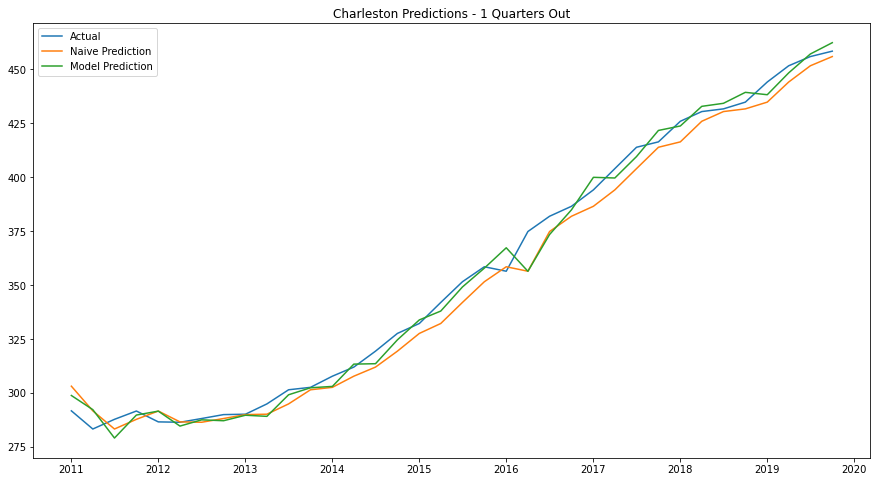

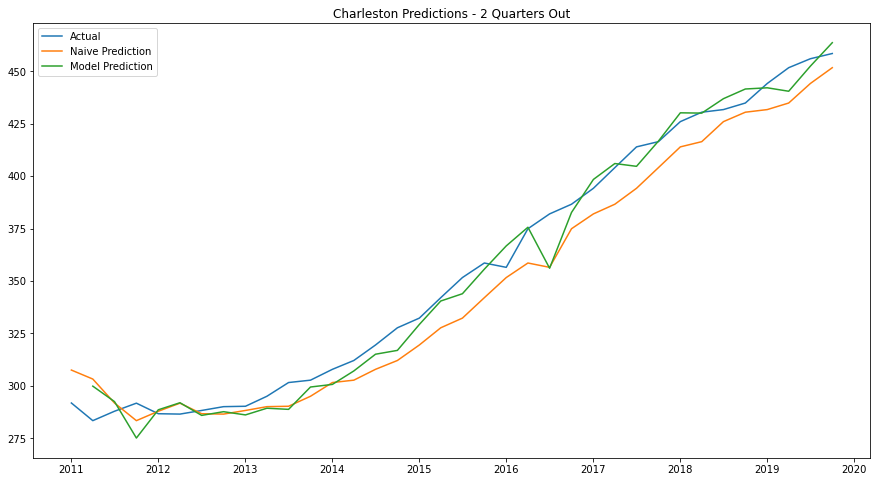

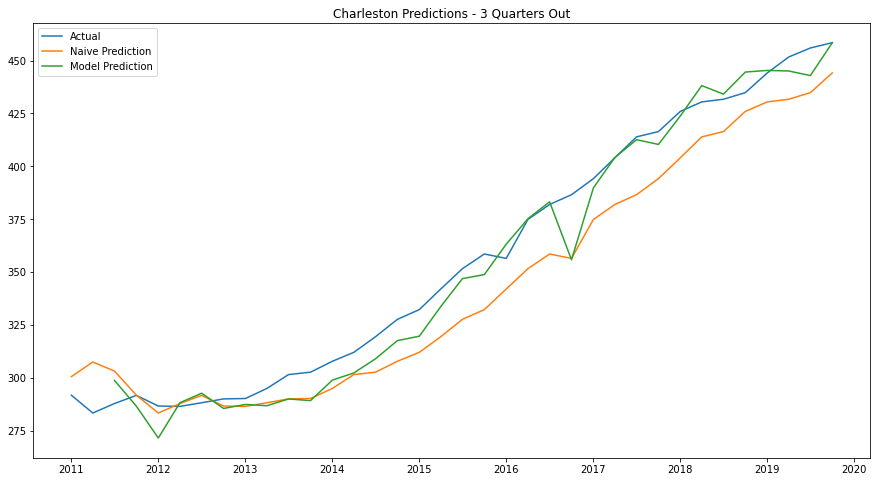

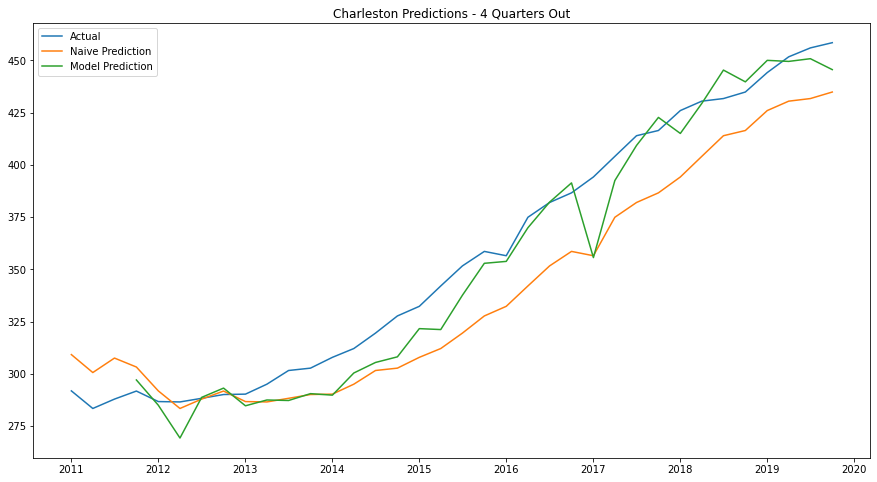

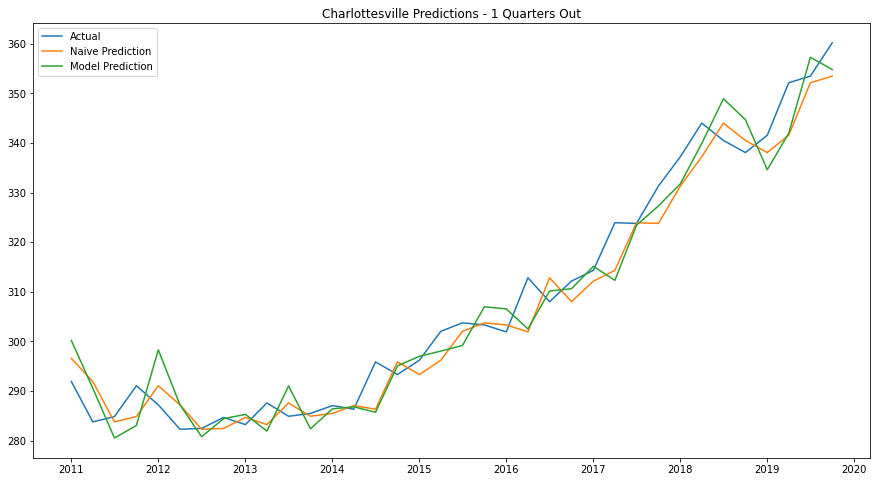

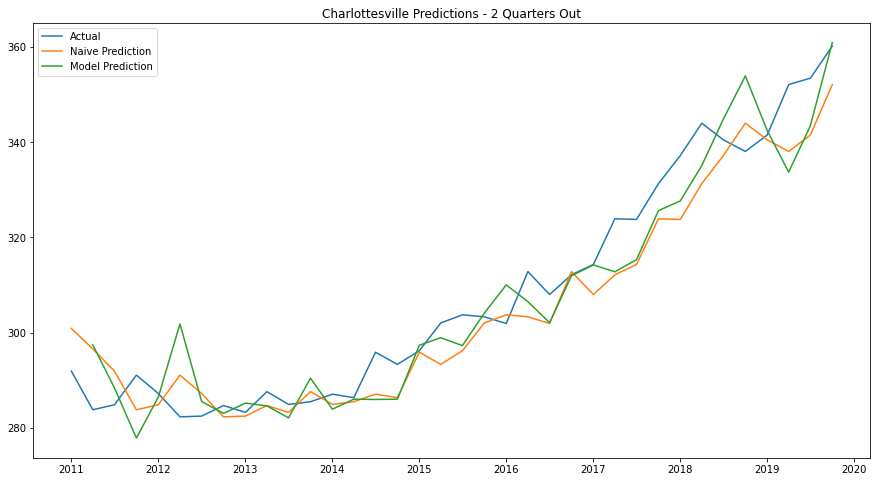

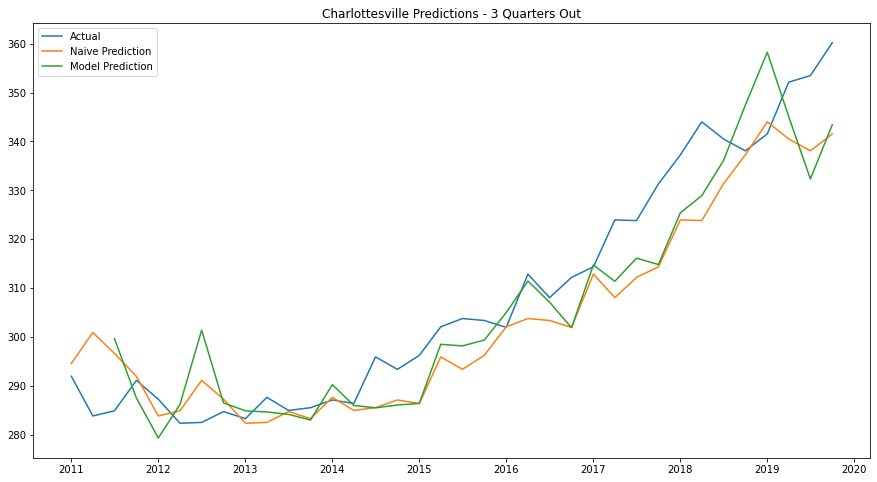

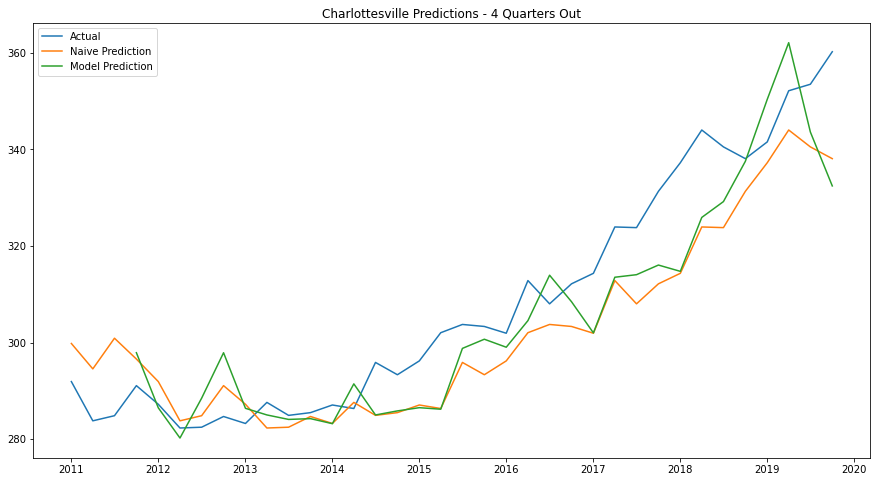

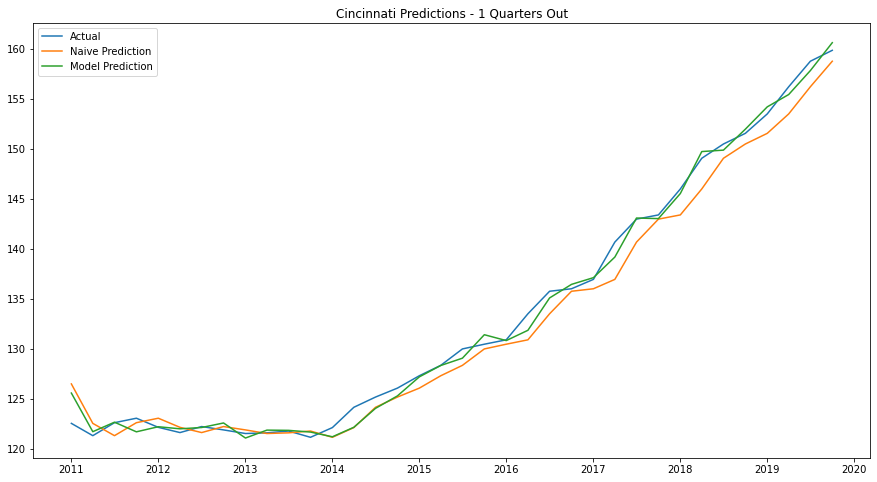

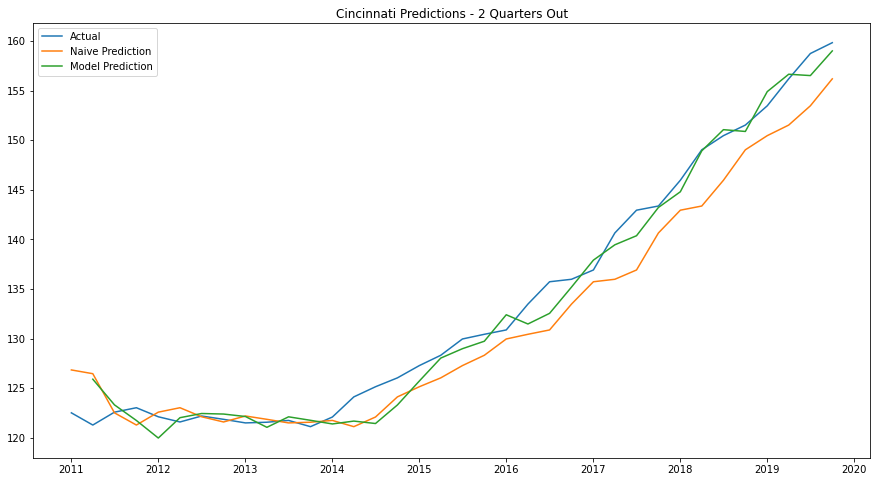

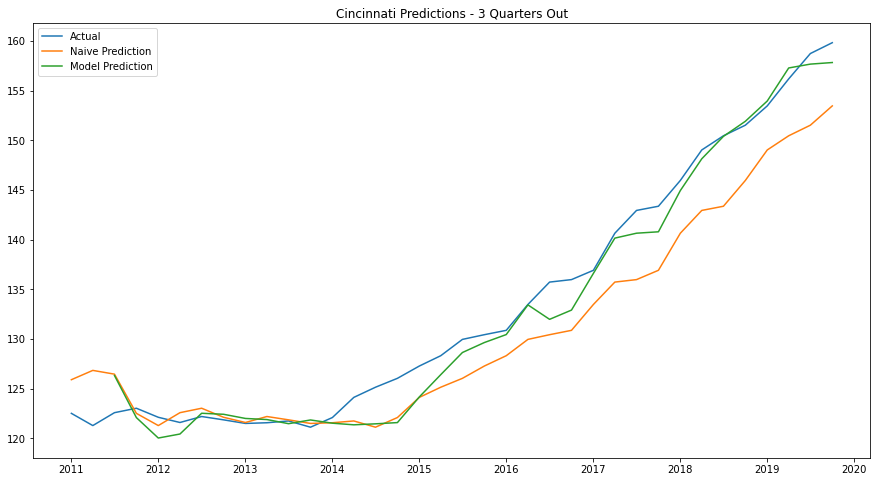

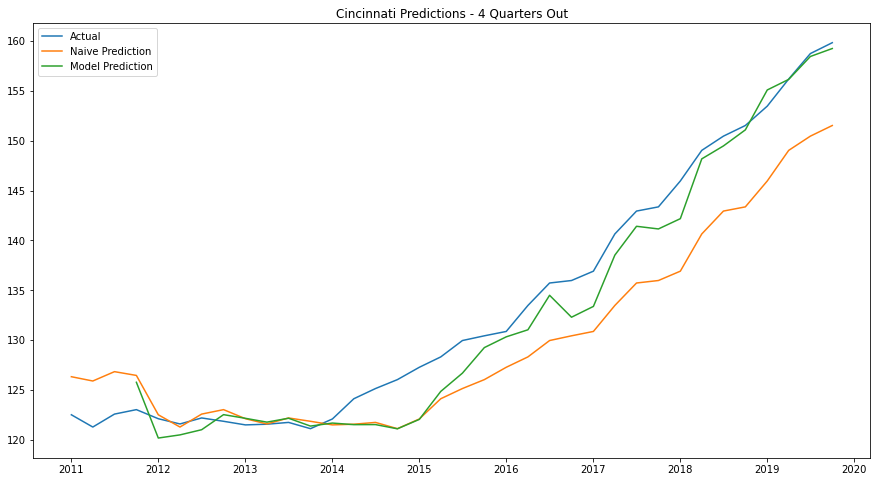

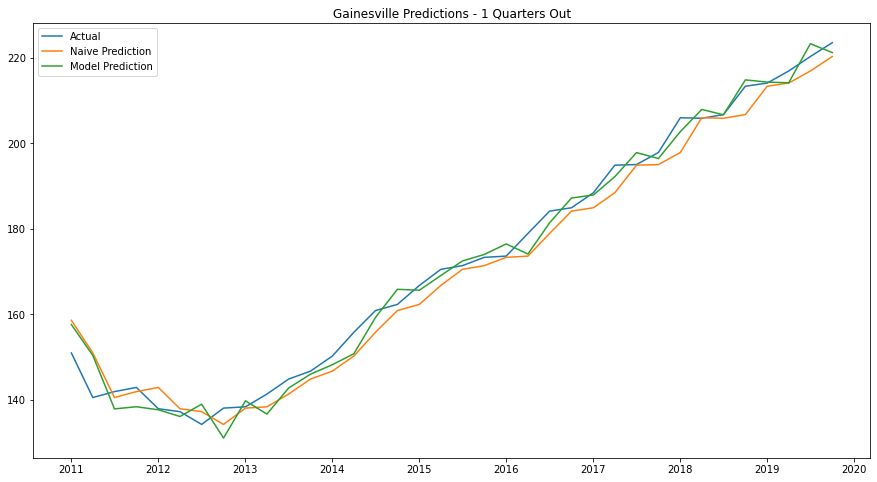

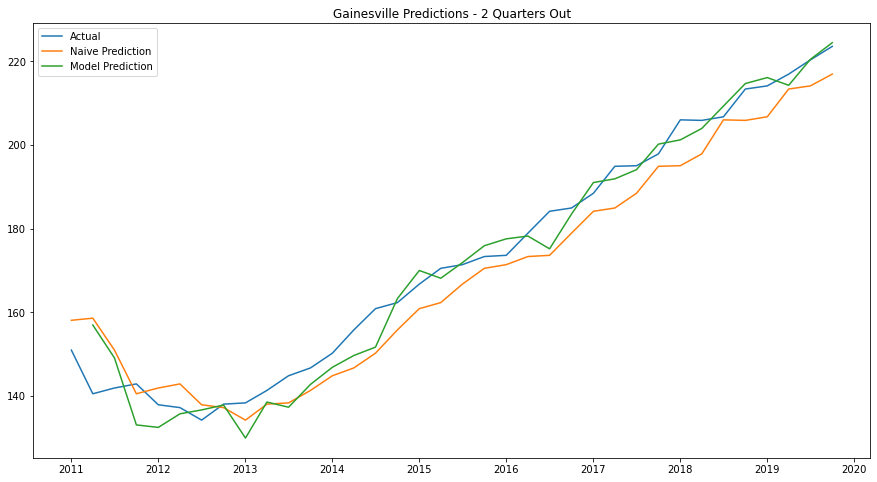

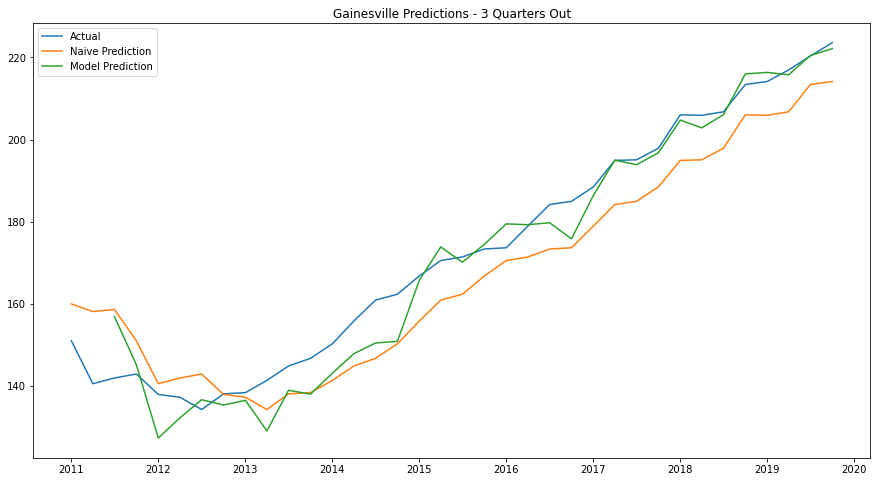

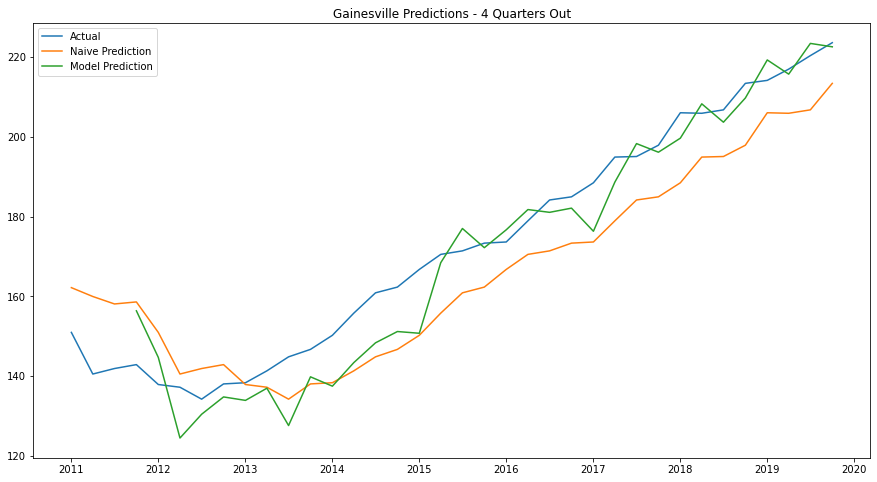

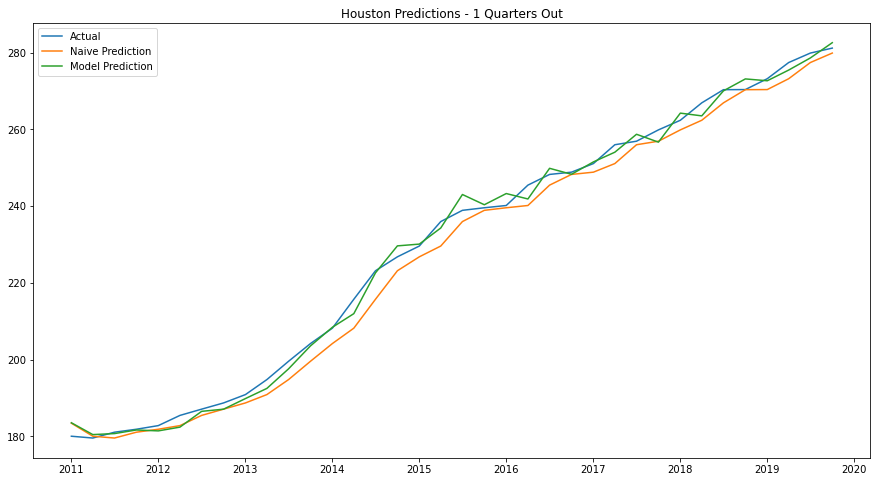

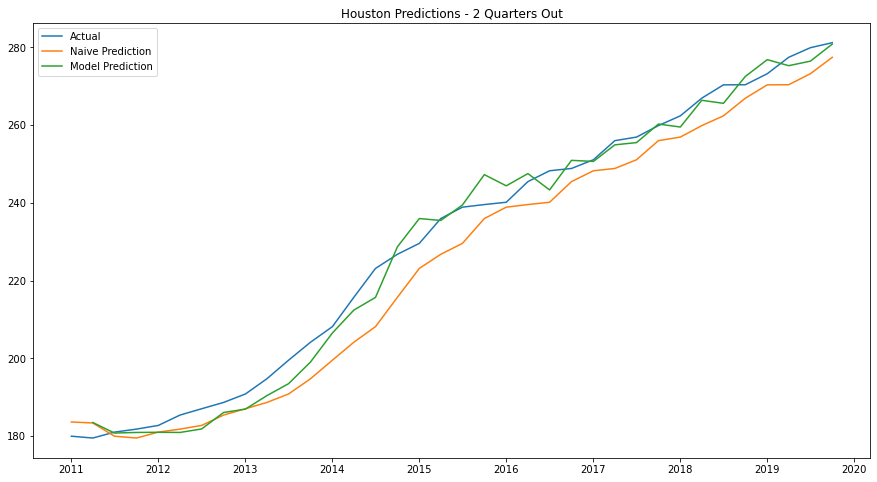

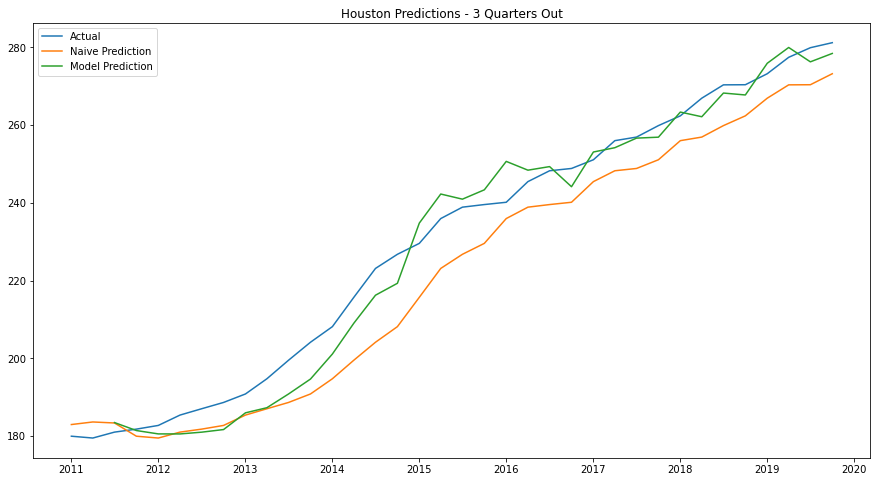

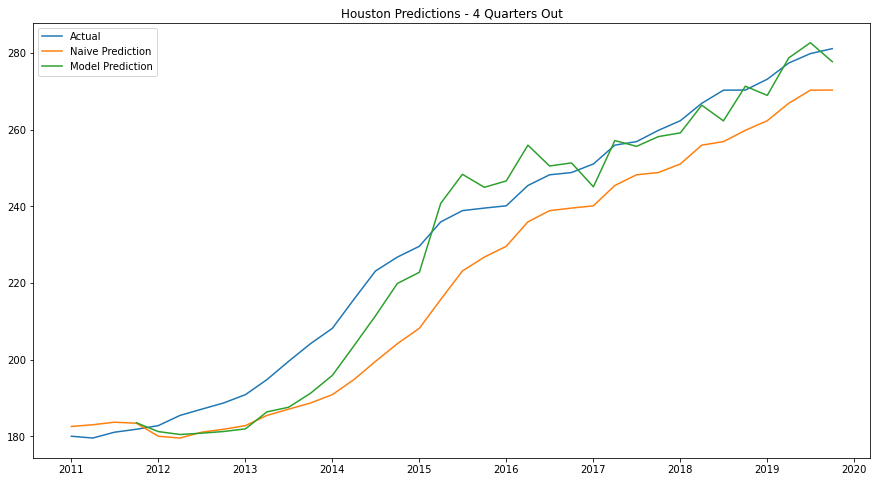

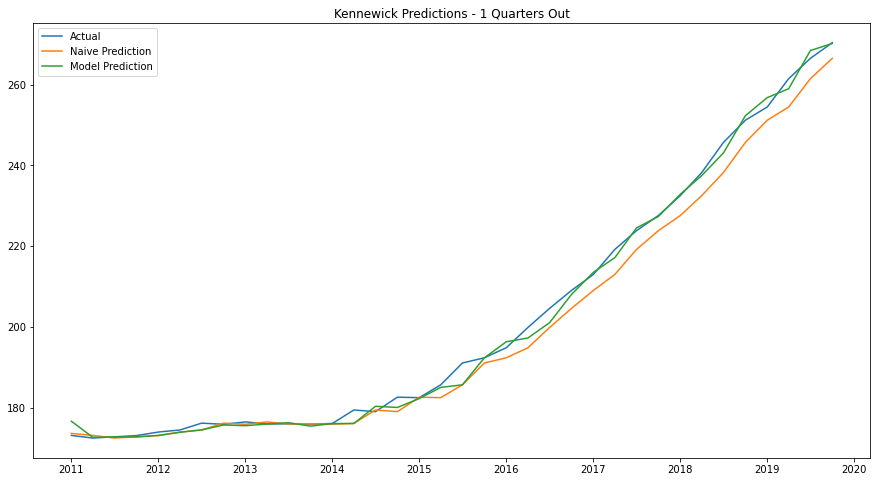

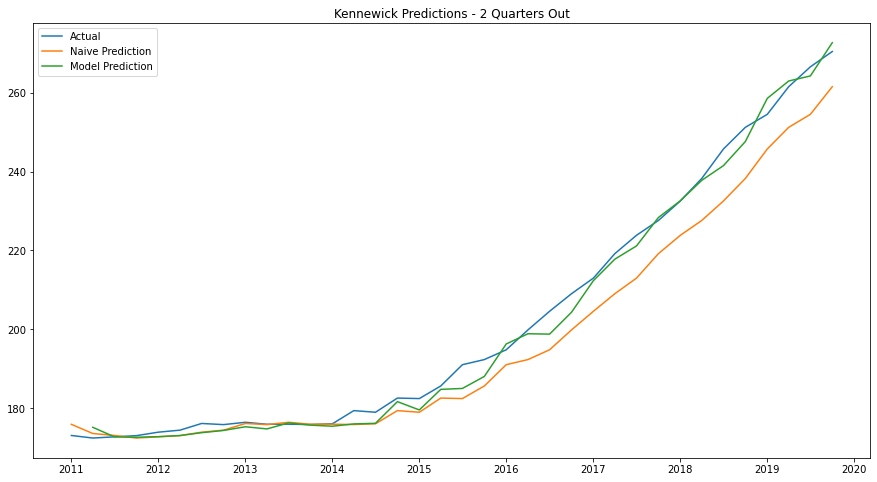

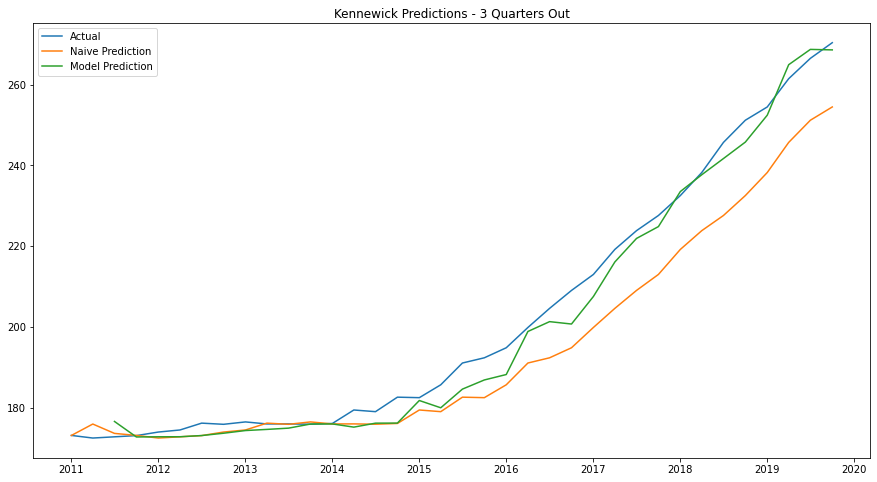

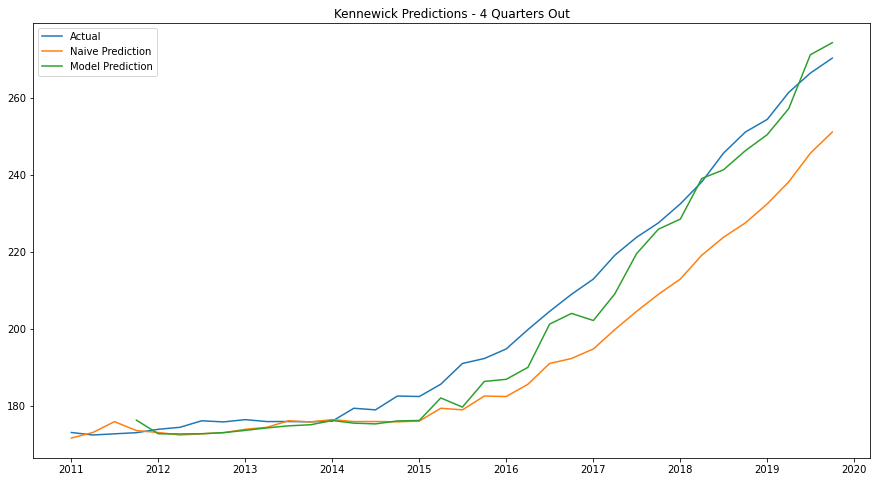

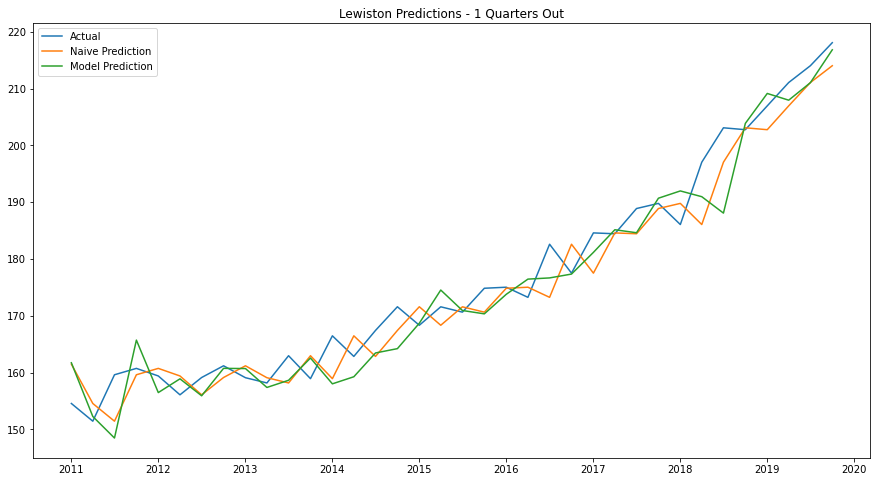

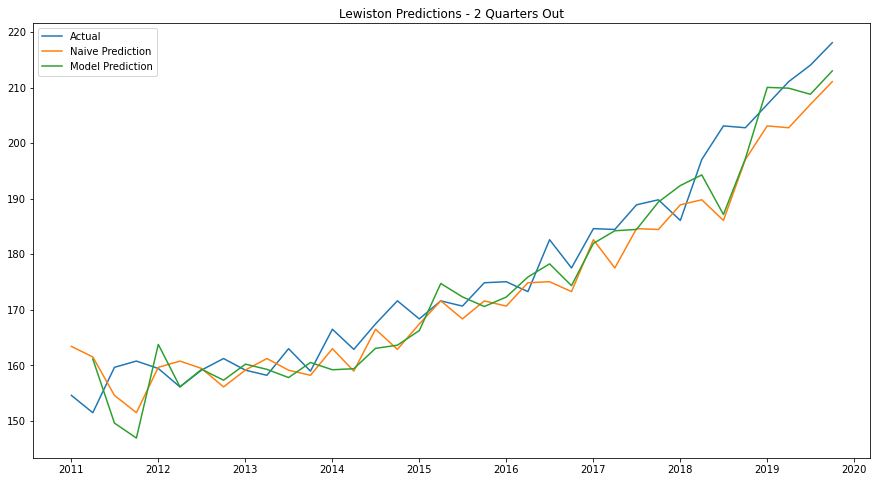

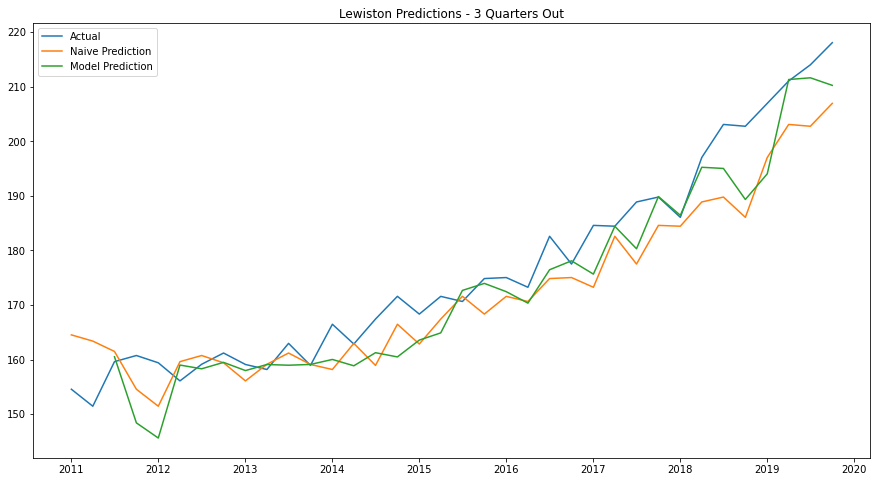

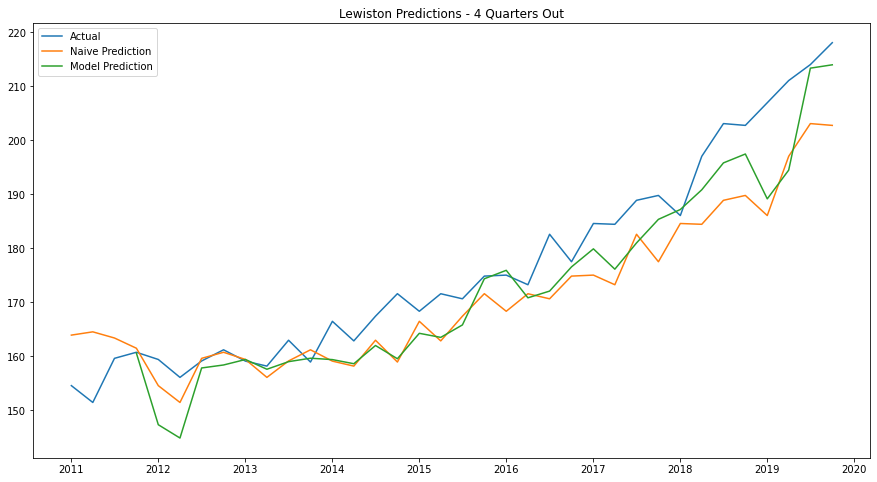

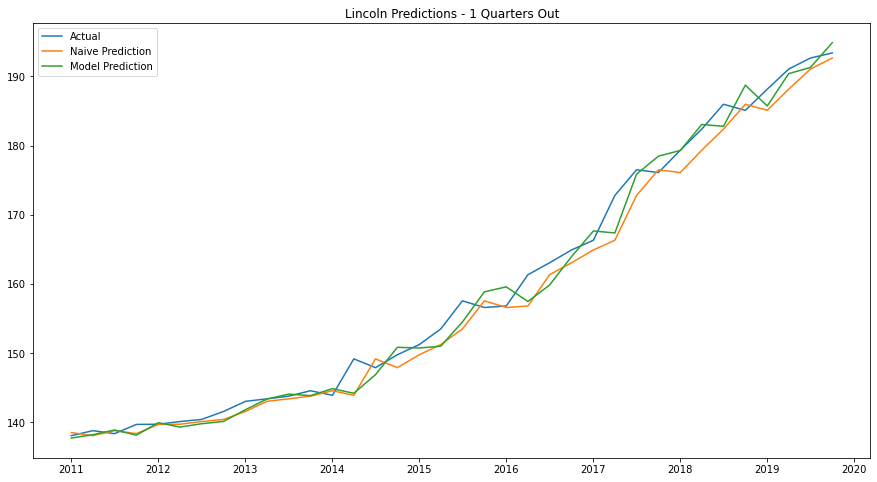

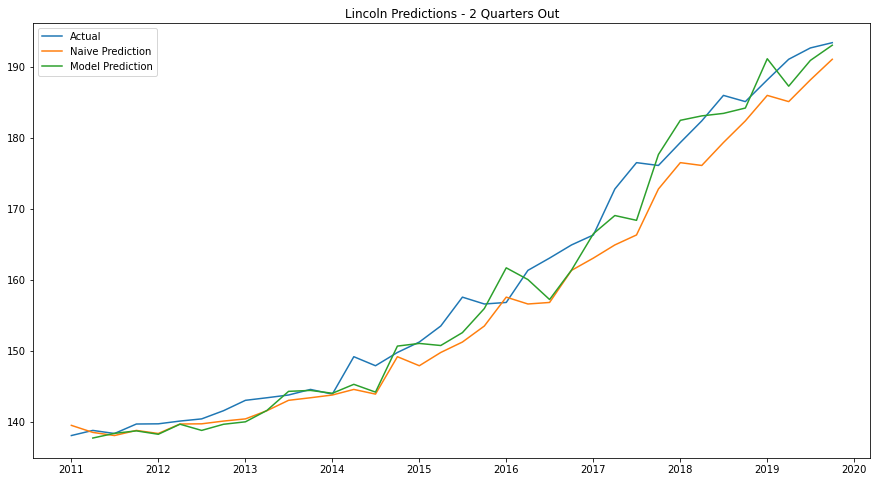

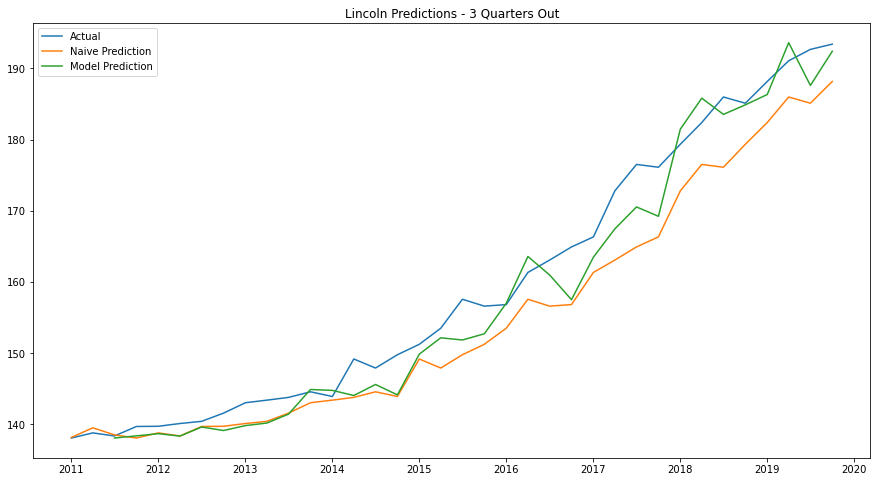

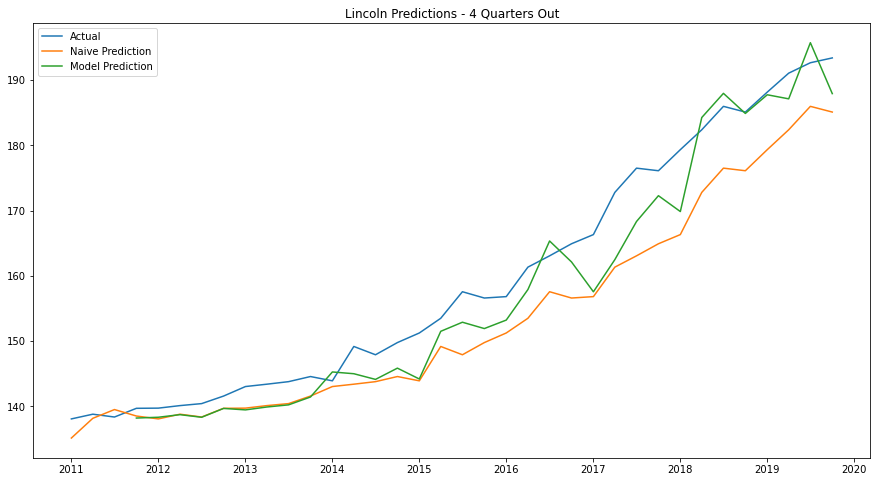

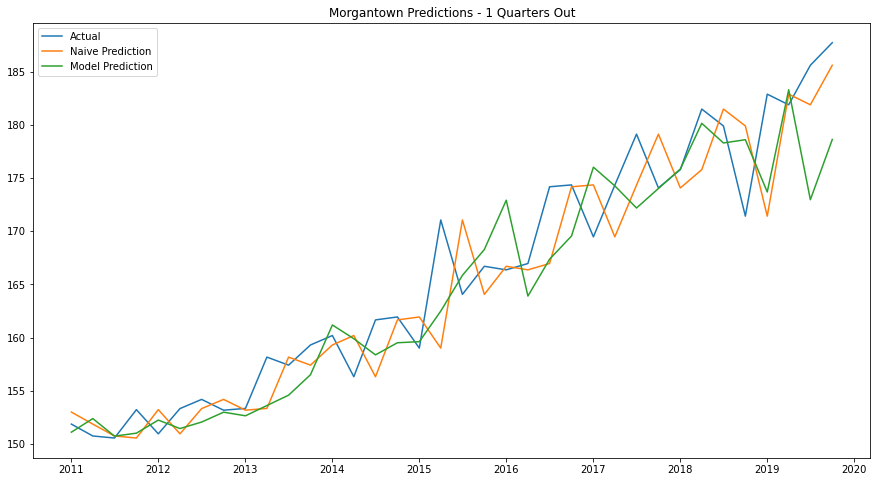

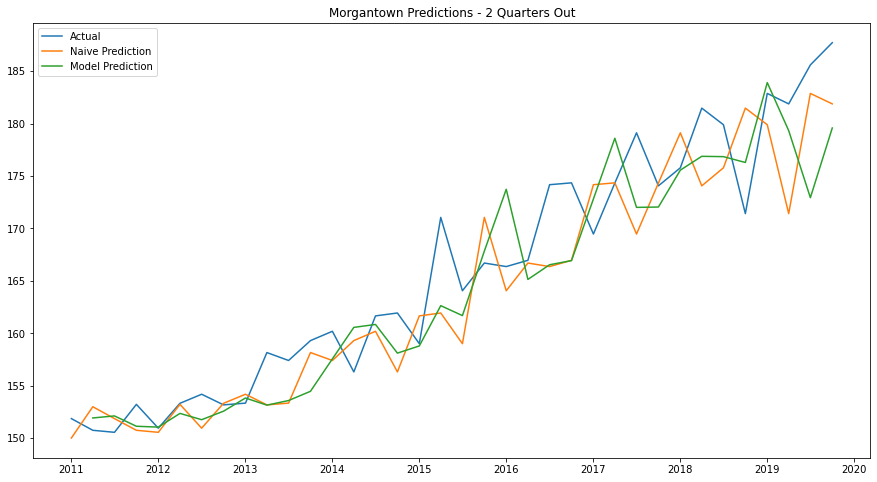

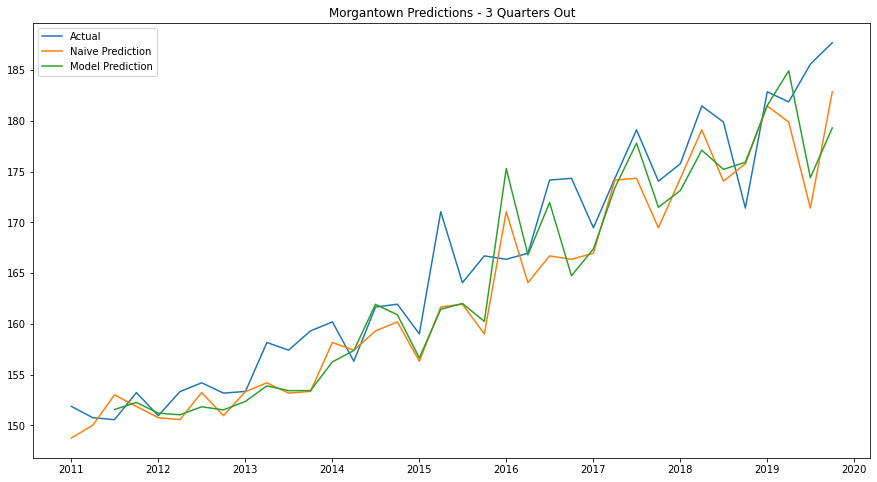

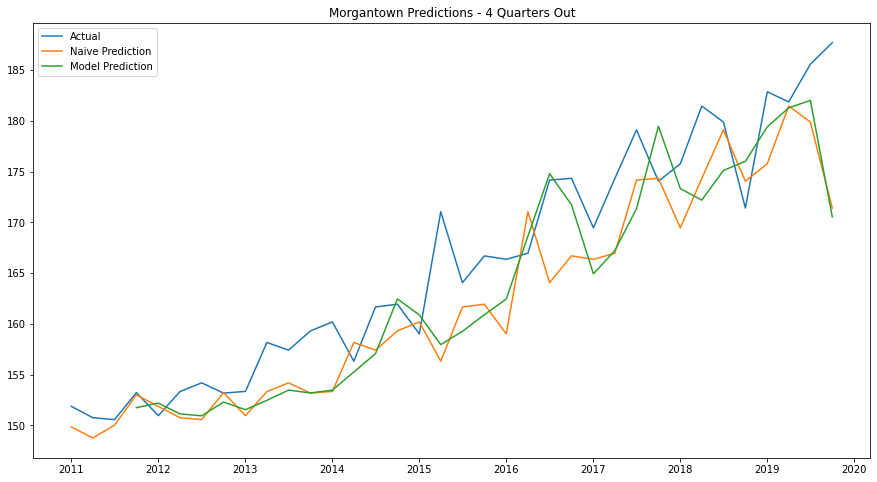

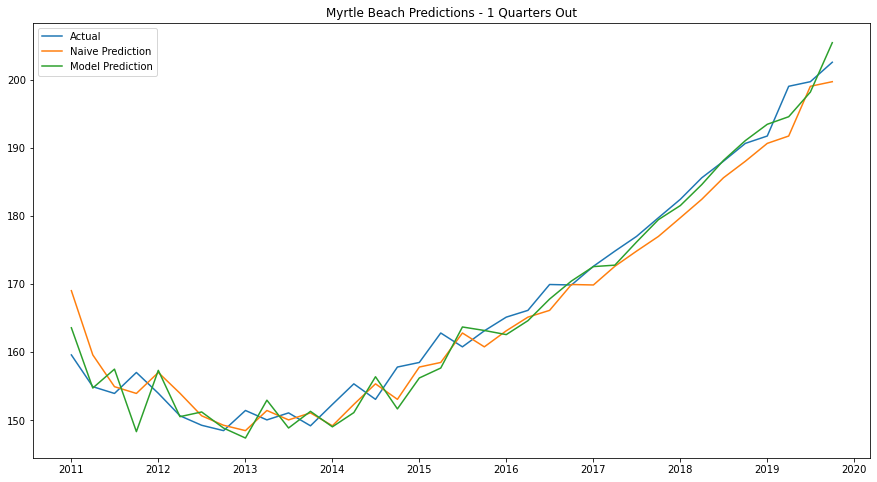

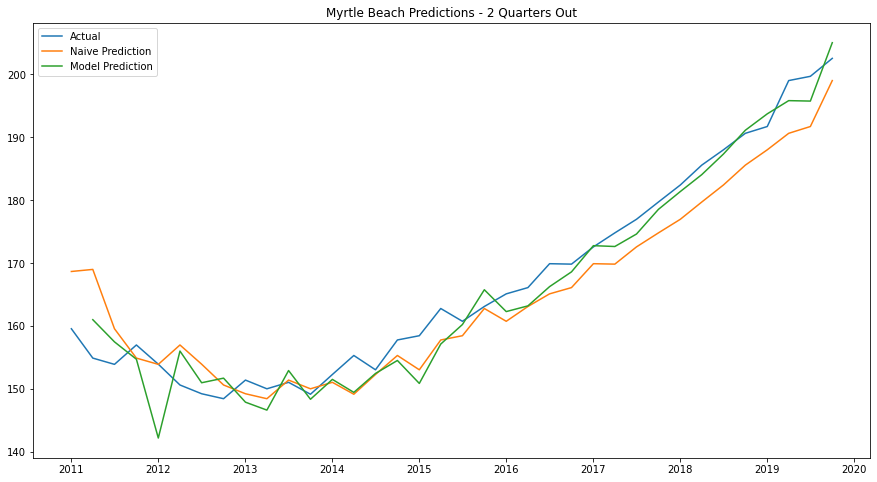

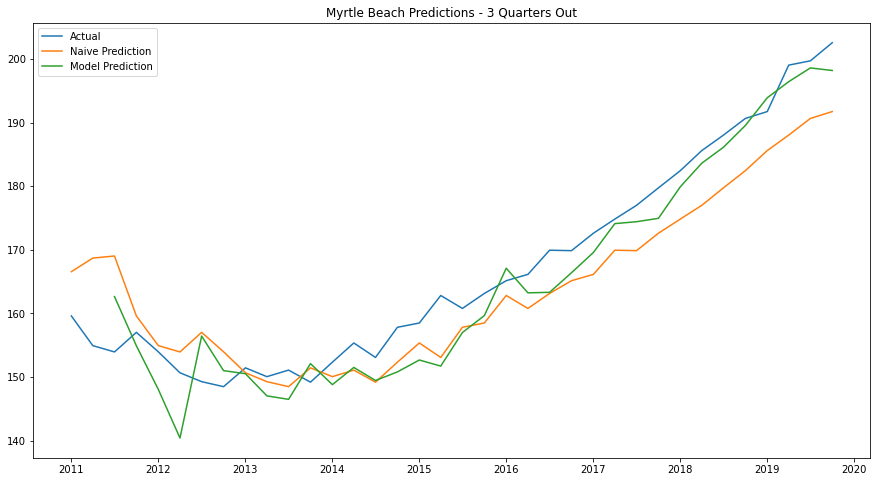

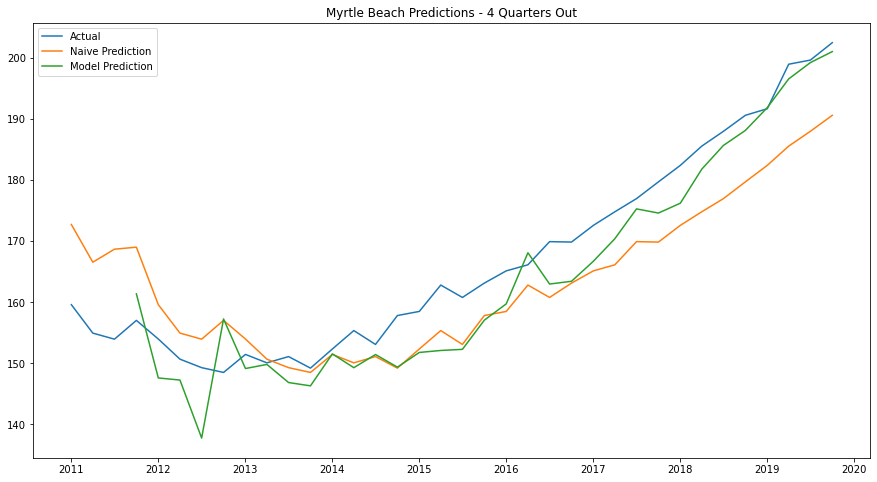

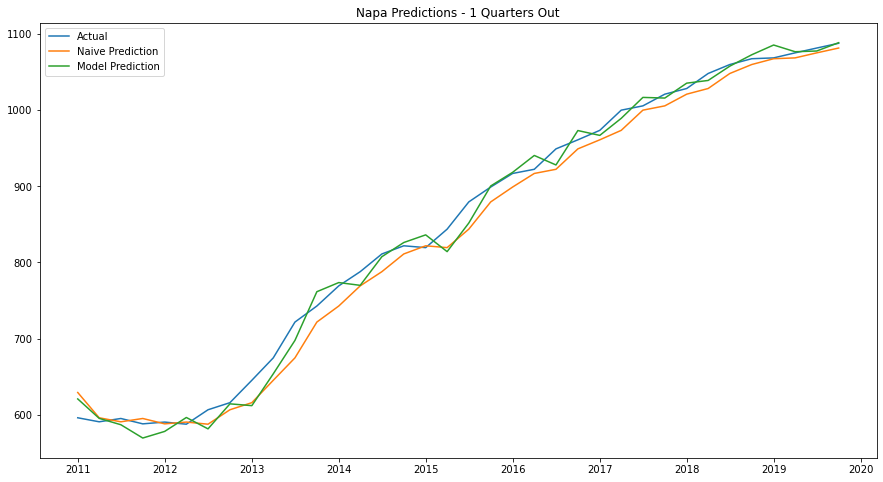

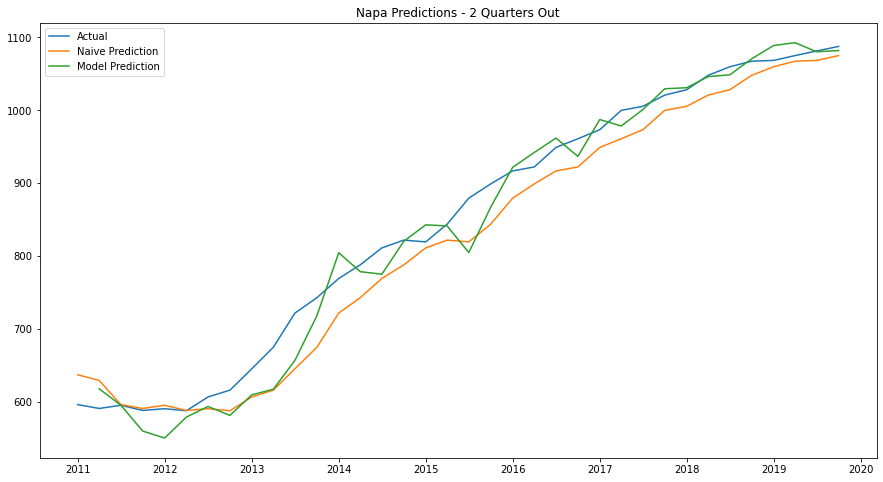

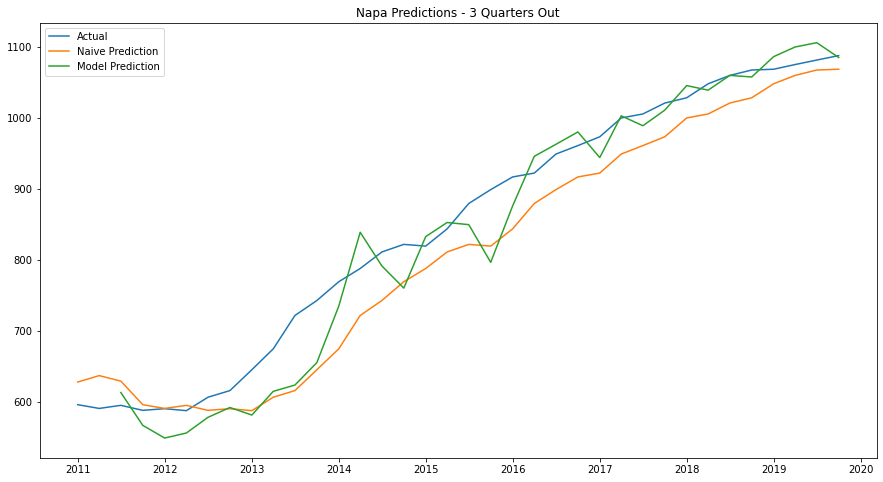

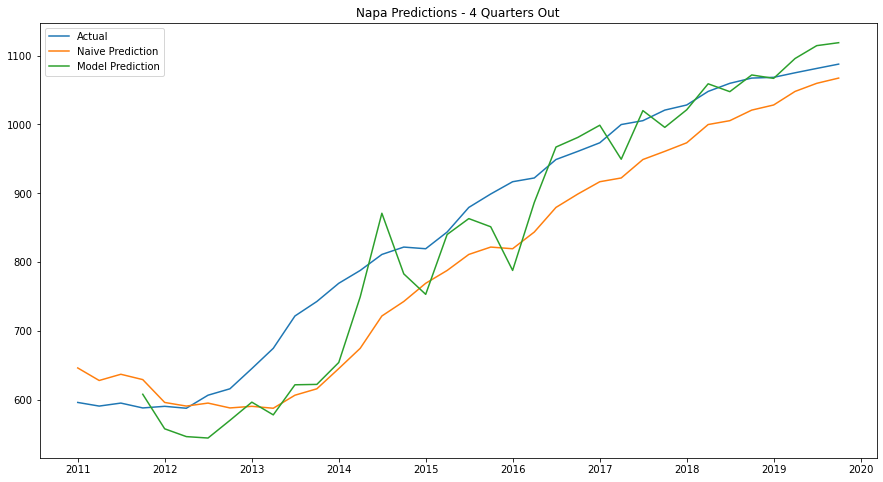

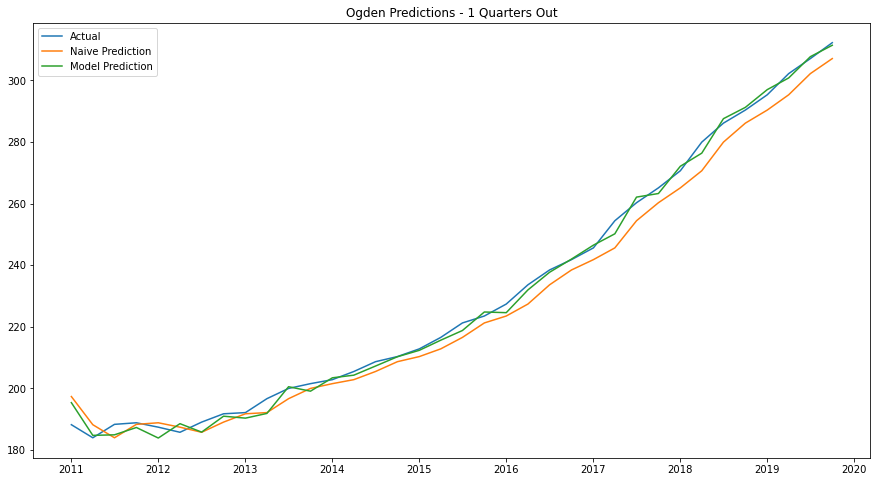

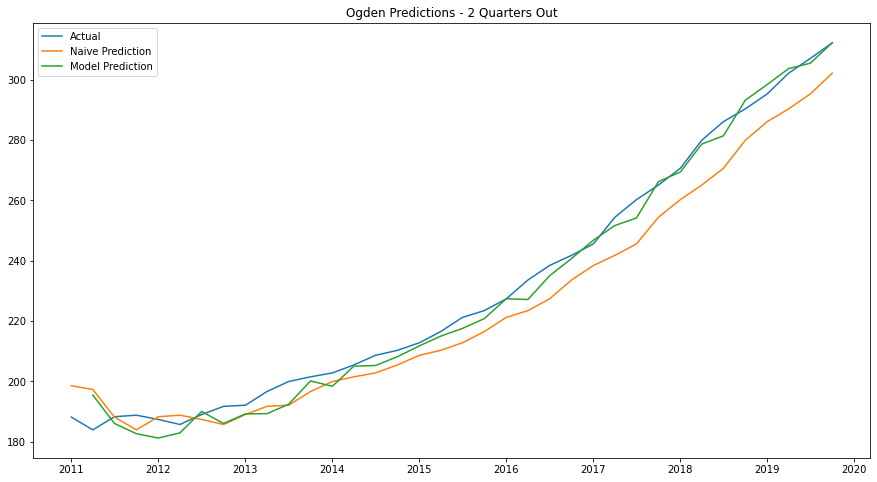

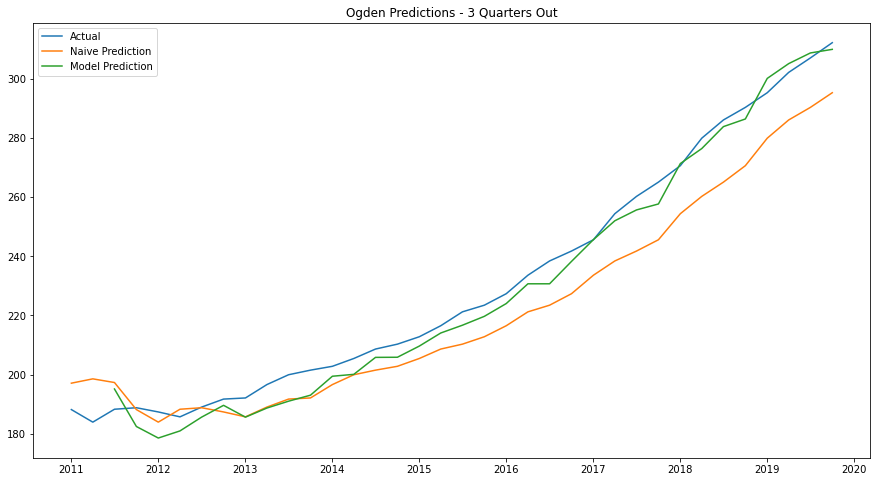

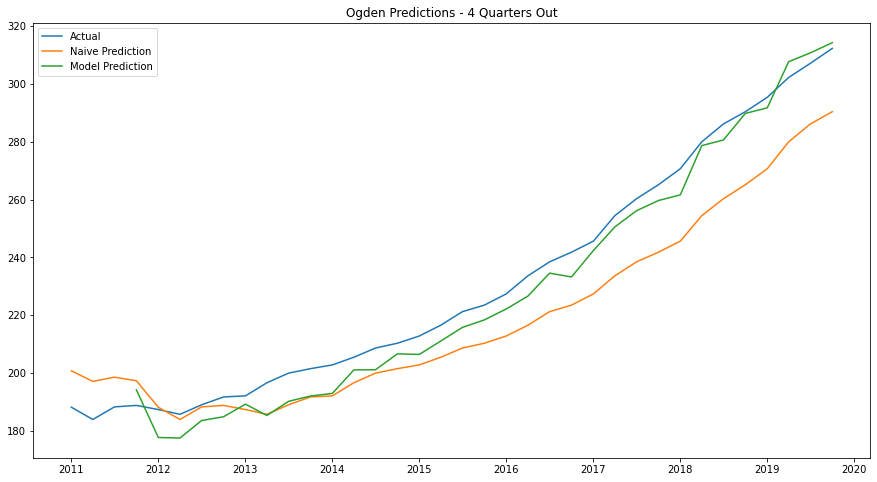

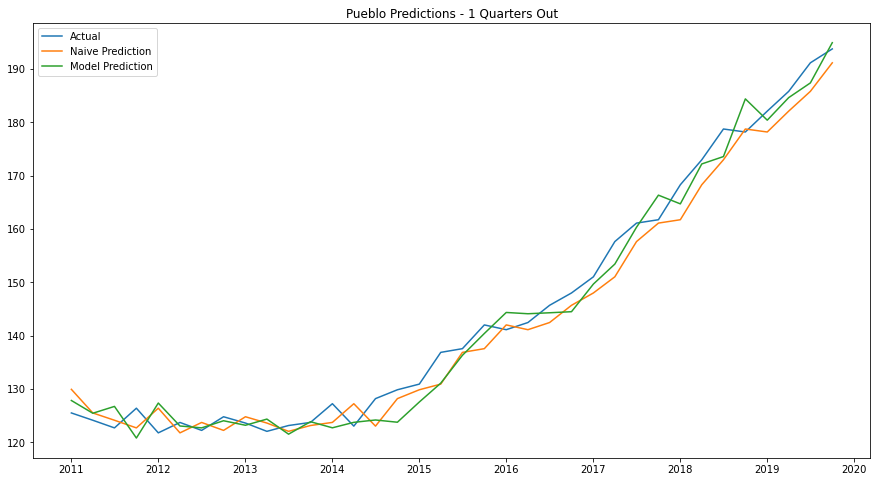

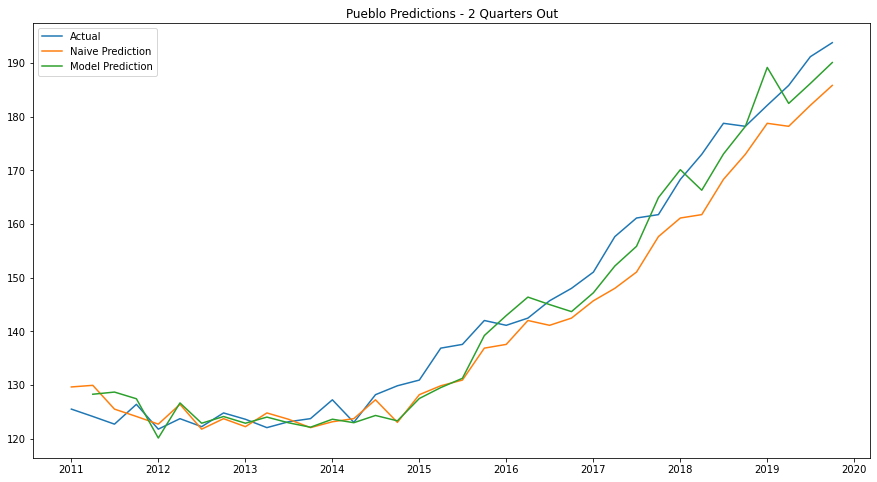

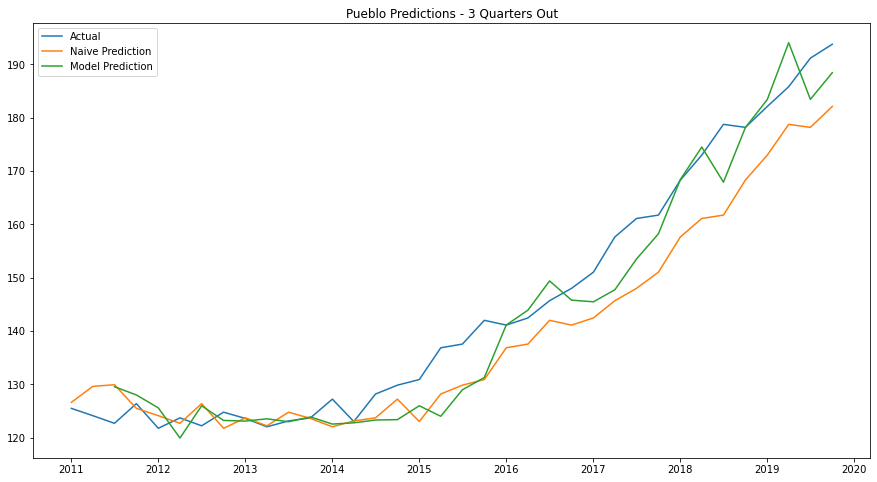

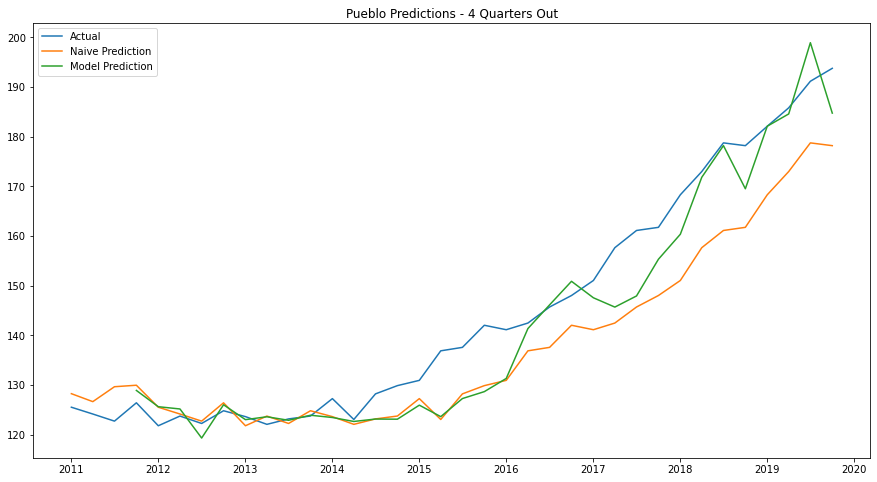

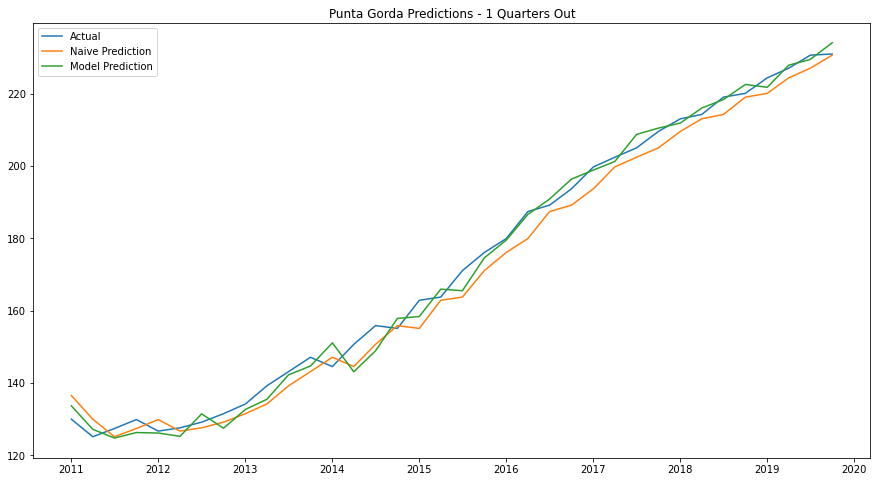

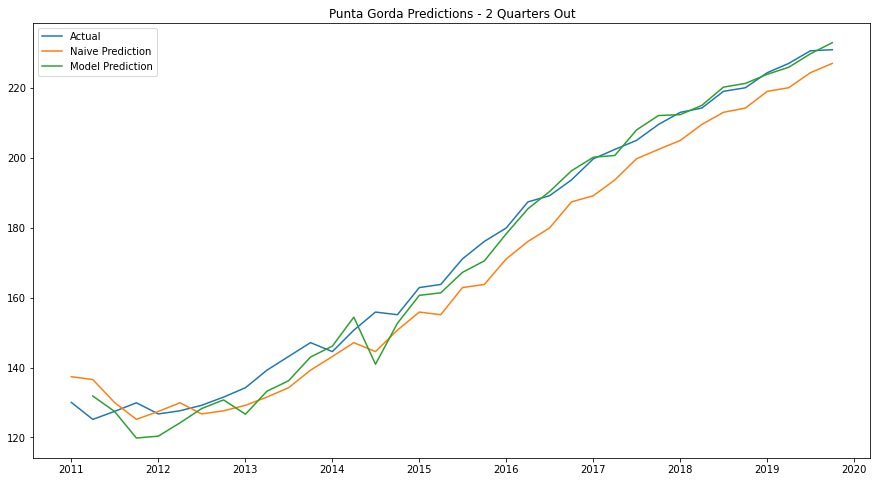

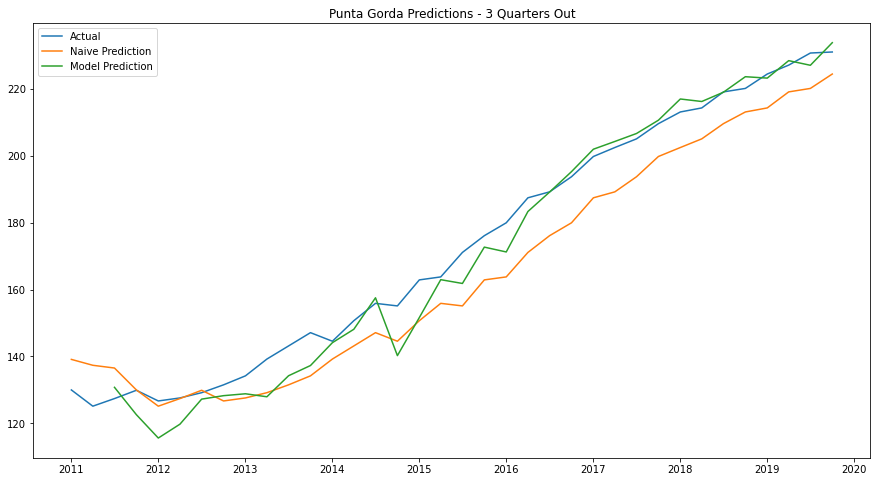

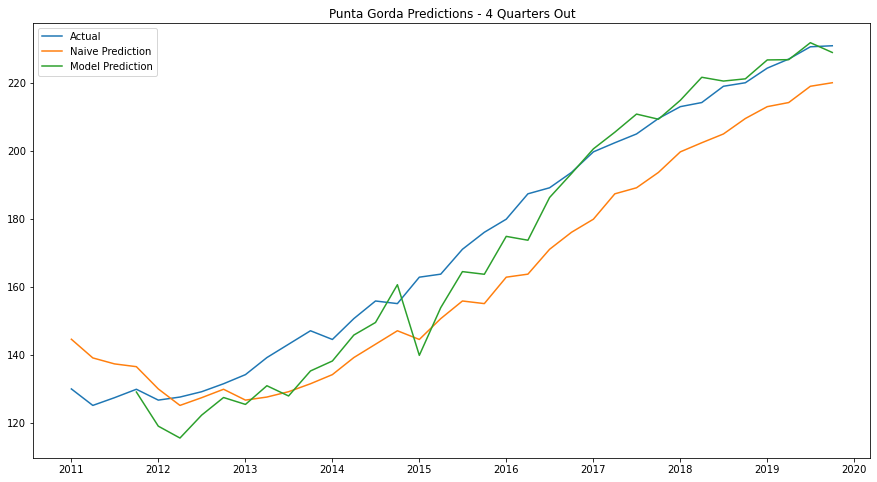

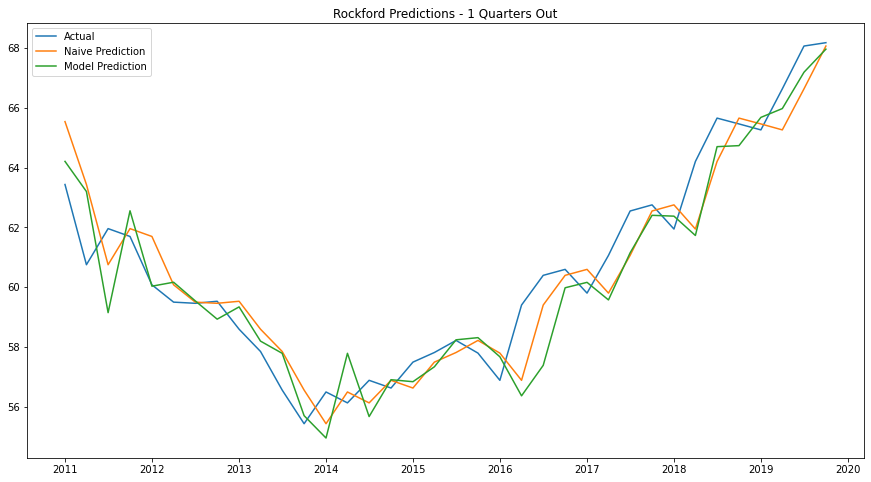

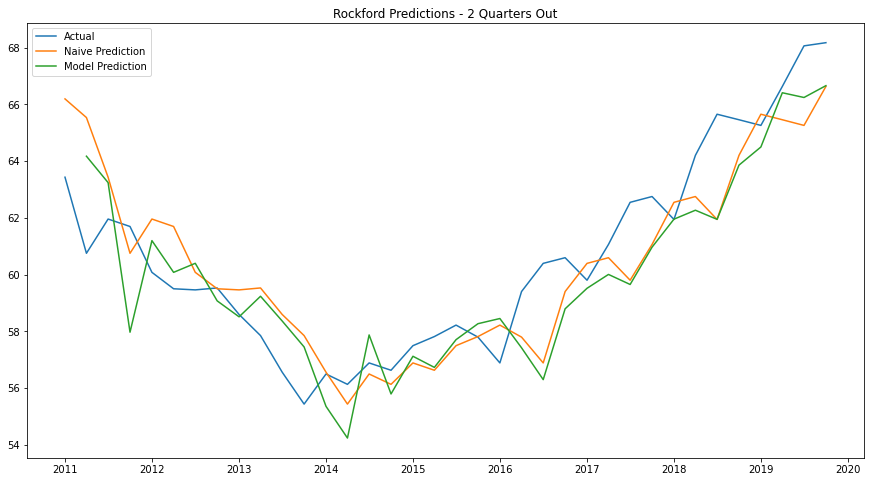

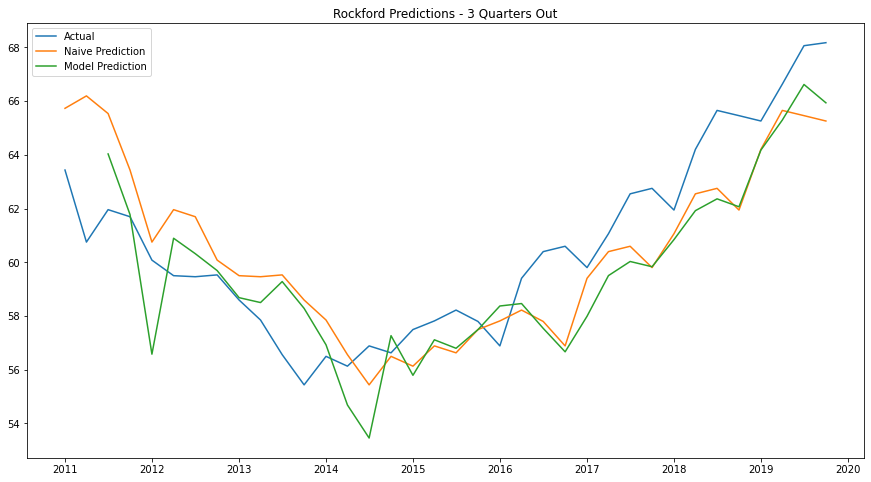

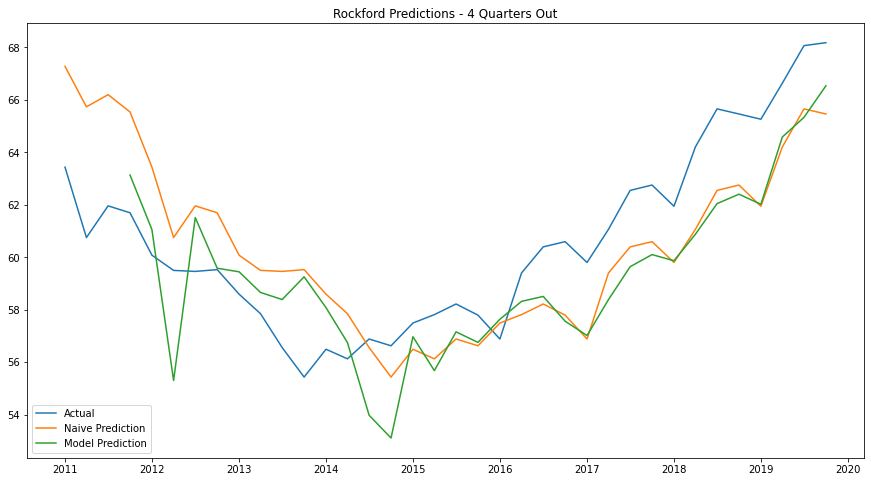

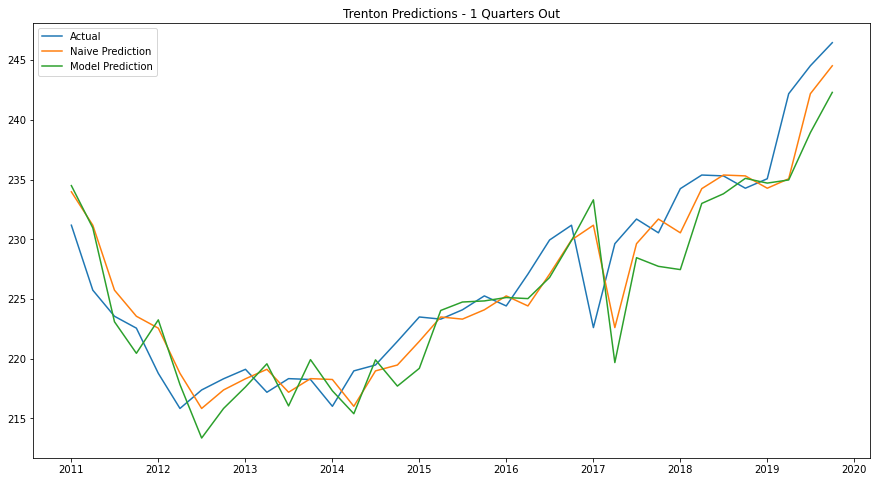

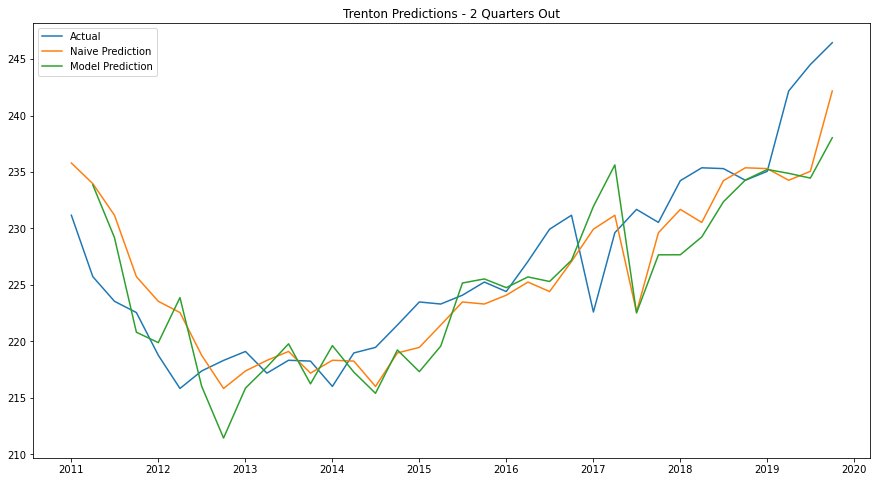

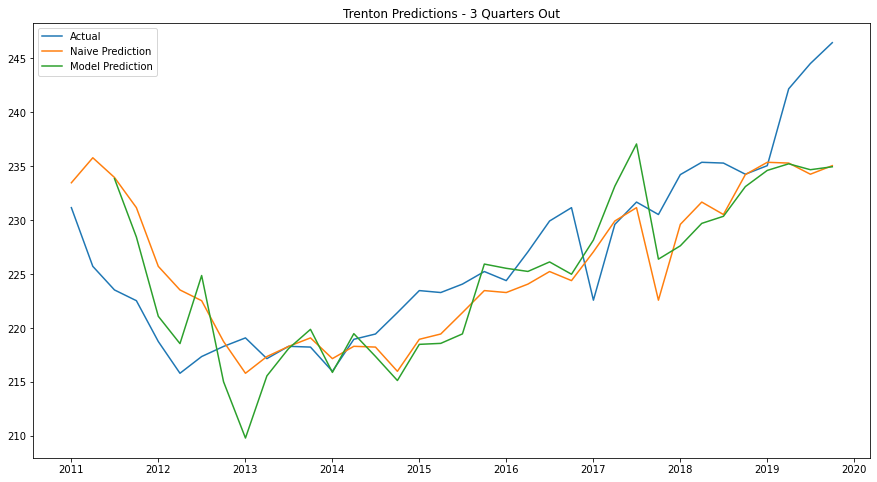

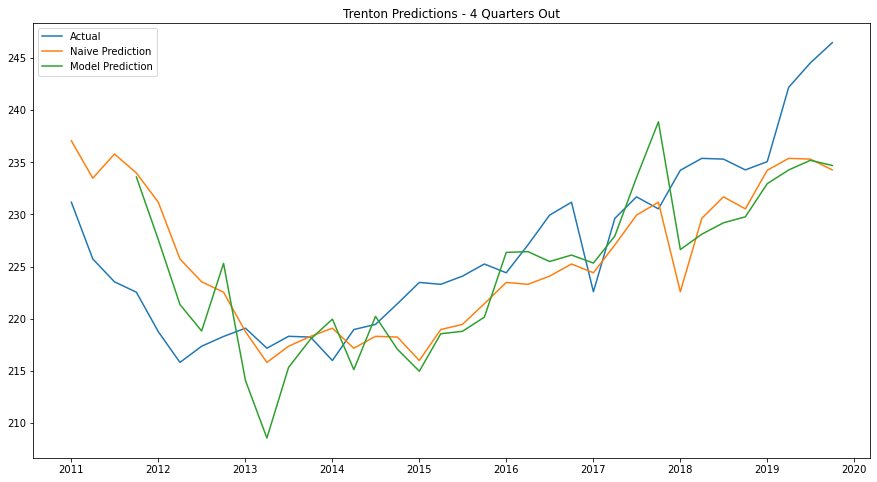

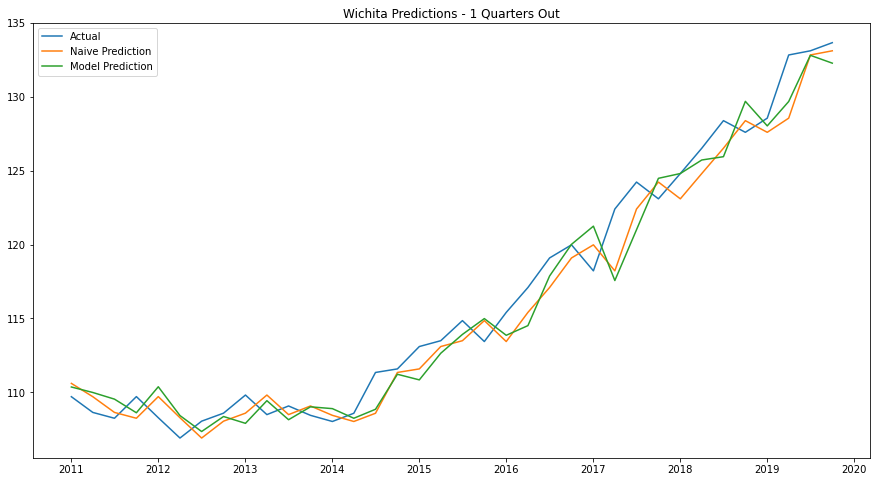

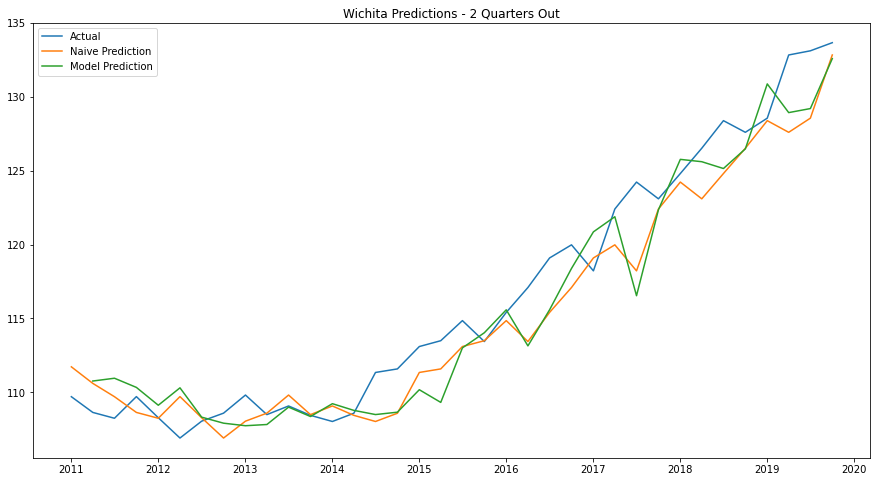

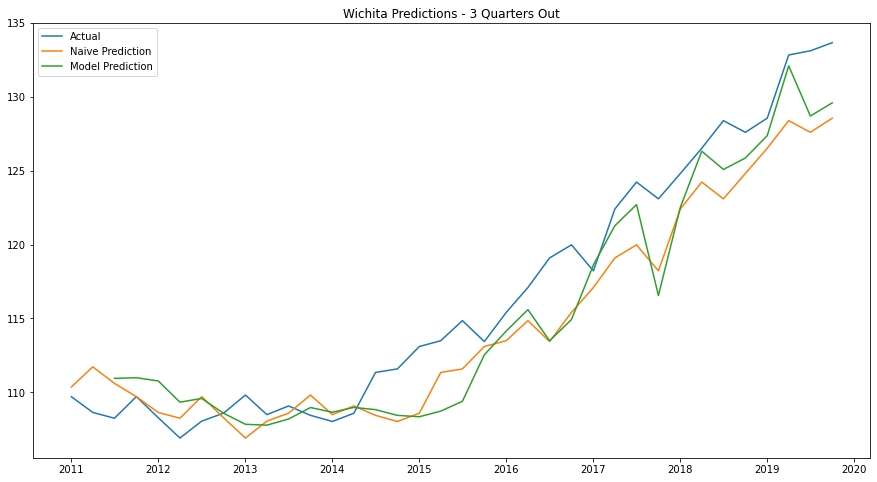

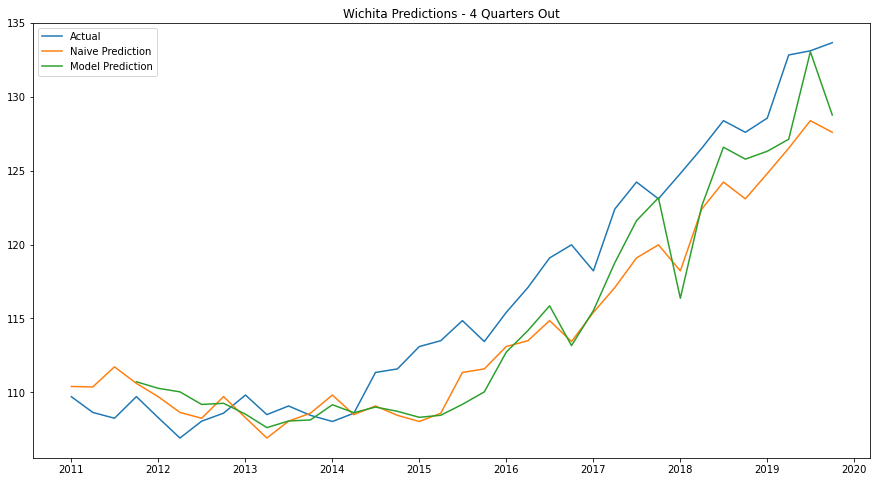

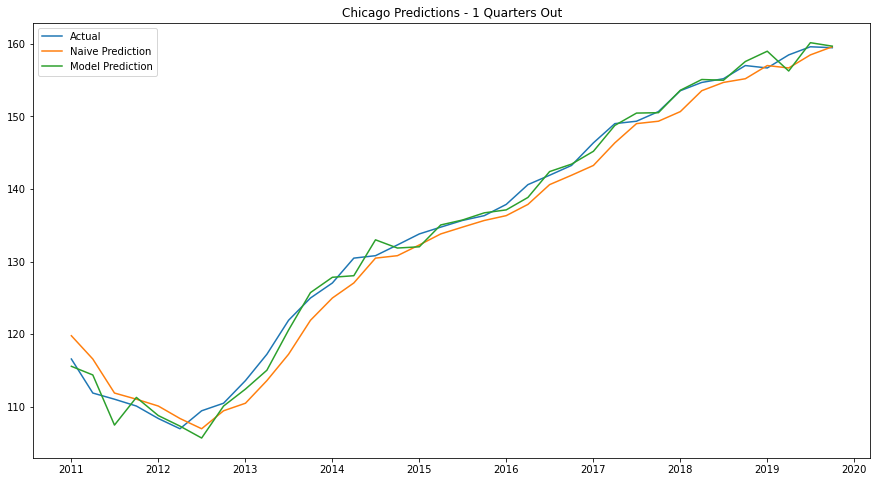

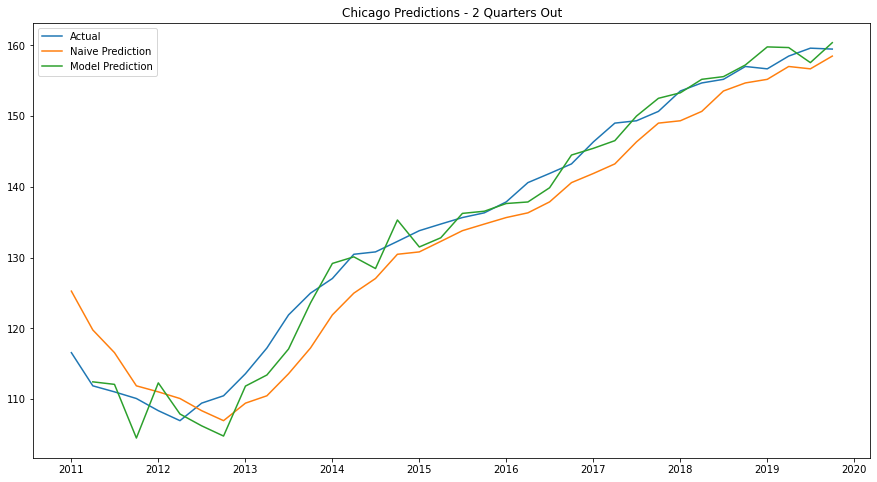

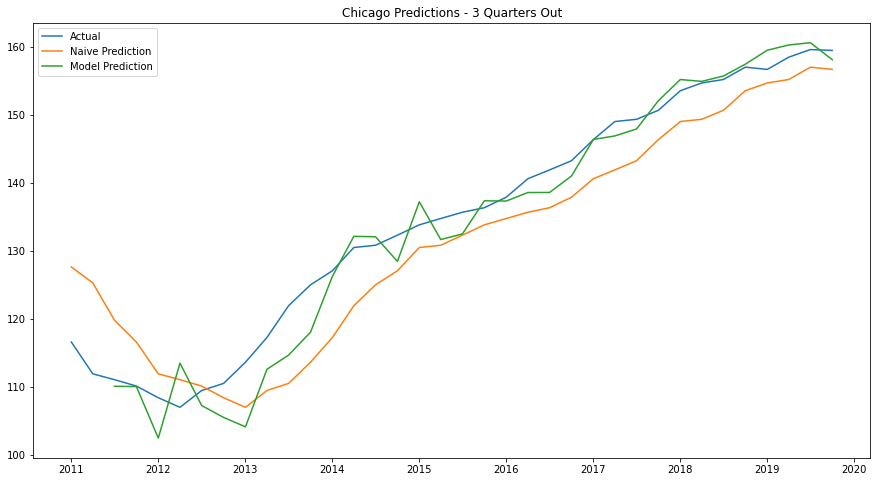

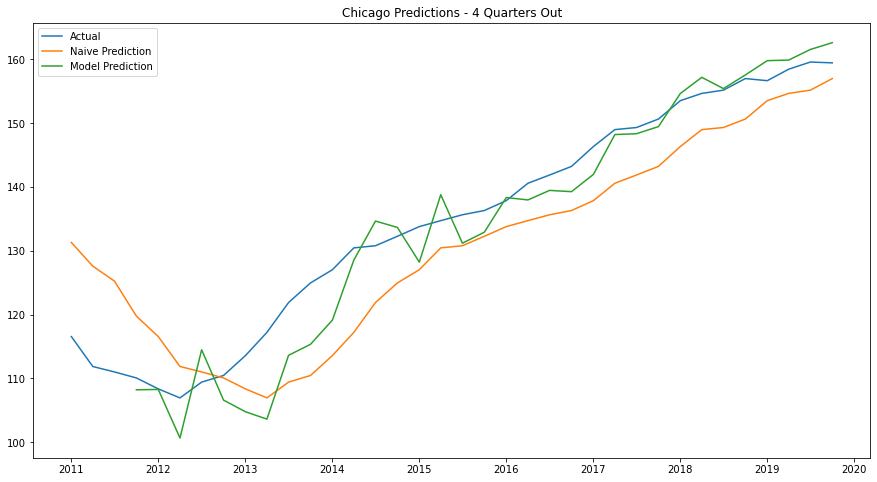

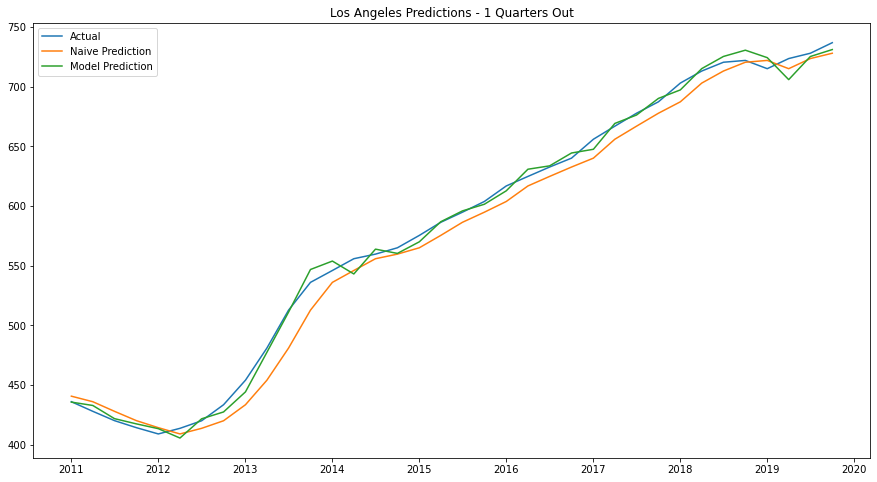

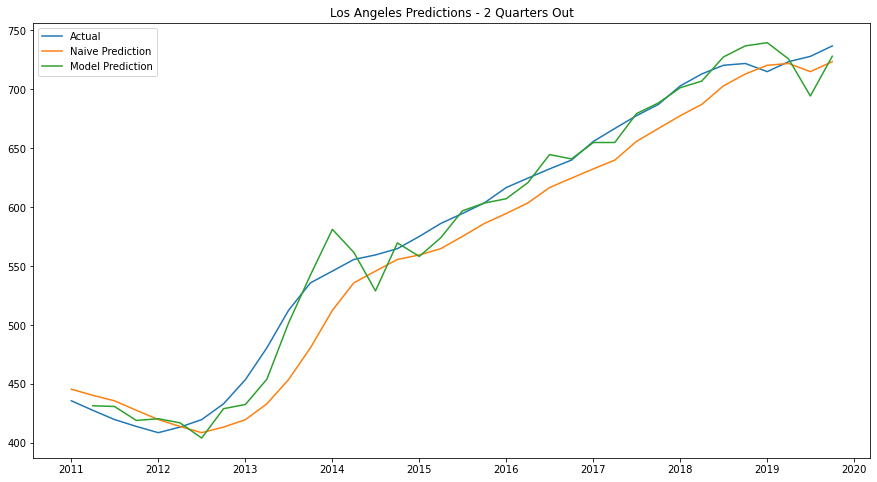

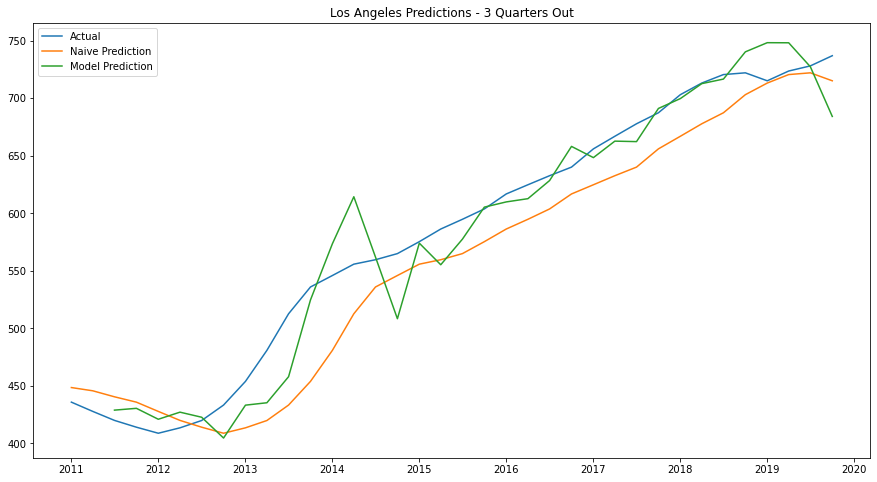

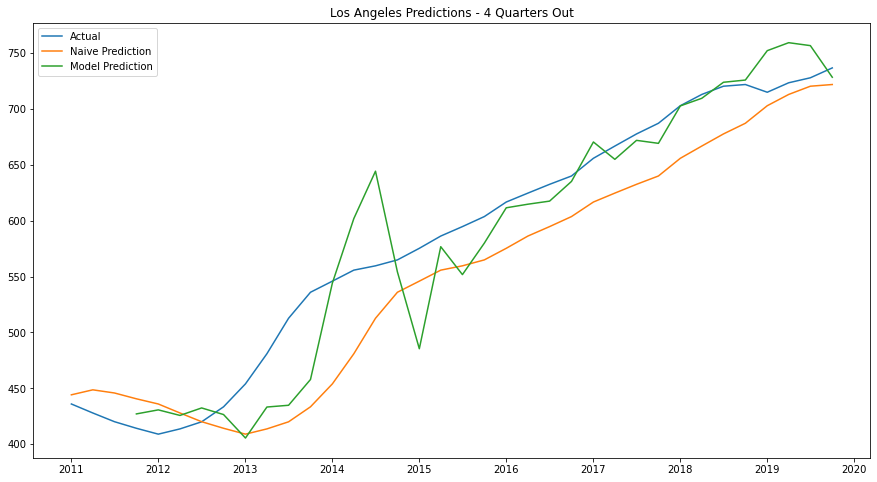

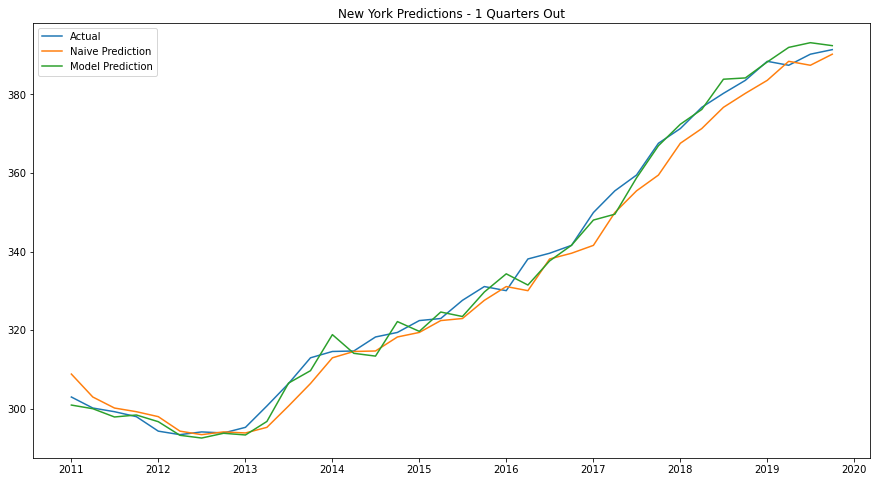

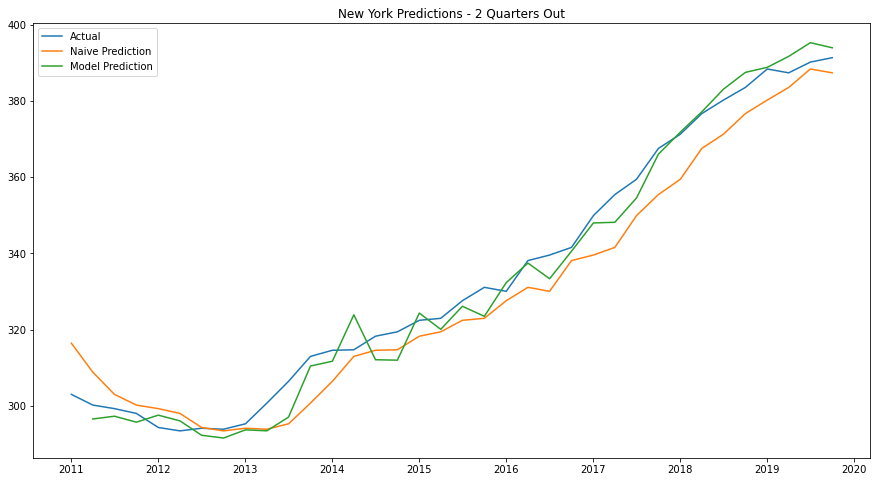

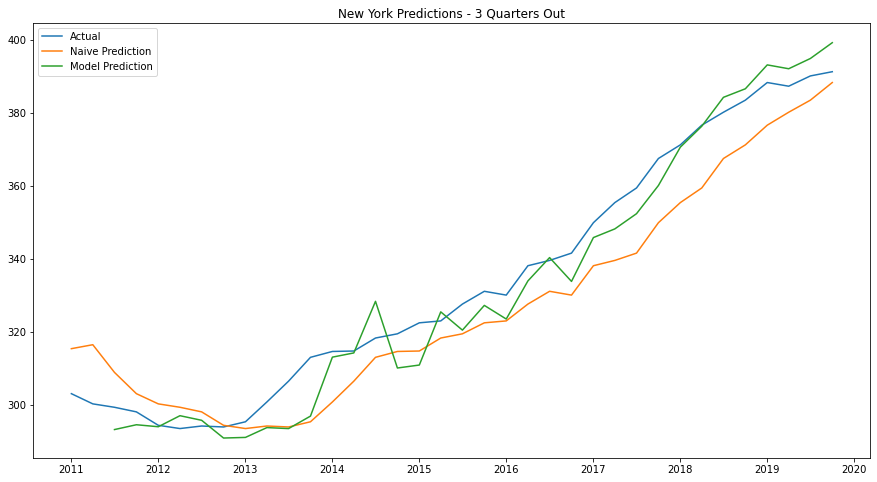

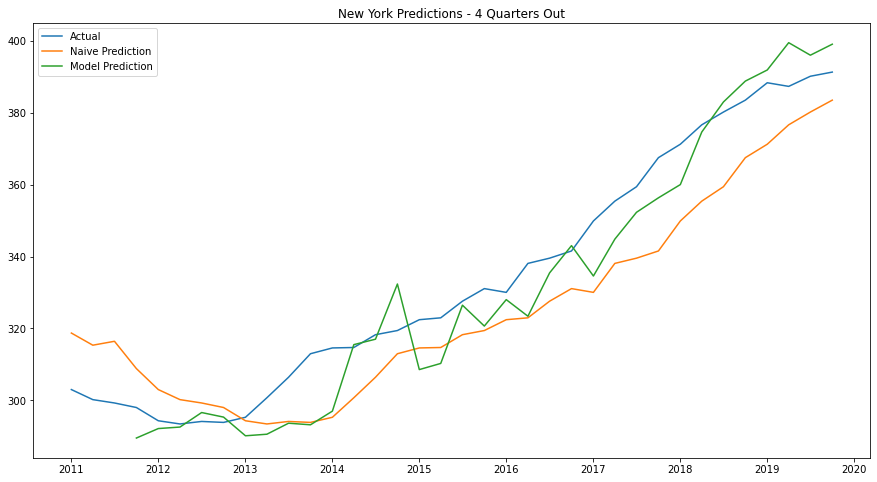

In [41]:
for city in best_model.city.unique():
    city_df = best_model[best_model.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(15,8))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.hpi, label='Actual')
        plt.plot(city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df[pred_col], label='Model Prediction')
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()